## Importing data and packages

In [1]:
# Importing packages
library(tidyverse)
library(plyr)
library(dplyr)
library(ggplot2)
library(caTools)
library(glmnet)
library(randomForest)
library(scales)
library(ggcorrplot)
library(caret)
library(gridExtra)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
<U+221A> ggplot2 3.1.1       <U+221A> purrr   0.3.2  
<U+221A> tibble  2.1.1       <U+221A> dplyr   0.8.0.1
<U+221A> tidyr   0.8.3       <U+221A> stringr 1.4.0  
<U+221A> readr   1.3.1       <U+221A> forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
------------------------------------------------------------------------------
You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)
------------------------------------------------

In [2]:
# Importing the HousePricesDataset
HousePricesHousePricesDataset <- read.csv('../House_Prices/data/train.csv')

In [3]:
# Size of HousePricesDataset
dim(HousePricesHousePricesDataset)

[1] 1460   81

In [4]:
head(HousePricesHousePricesDataset, 10)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000
8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
10,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,1,2008,WD,Normal,118000


In [5]:
HousePricesPredictorV <- as.matrix(HousePricesHousePricesDataset[, -81])
HousePricesTargetV <- HousePricesHousePricesDataset[, c('SalePrice')]


## Analysing the most important numeric variables

NULL

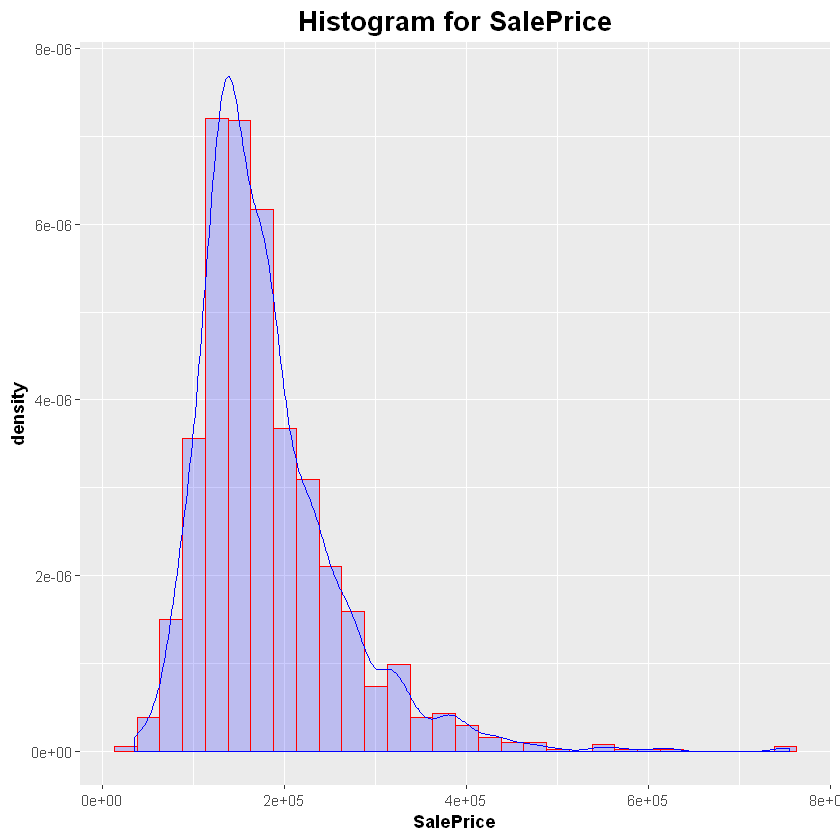

In [6]:
# Response variable 'SalePrice'
ggplot(data = HousePricesHousePricesDataset[!is.na(HousePricesHousePricesDataset$SaleType), ], aes(x = SalePrice)) + 
  geom_histogram(aes(y =..density..),
                 col = "red", 
                 fill = "blue", 
                 alpha = .2,
                 binwidth = 25000) + 
  geom_density(col = 4) + 
  labs(title = "Histogram for SalePrice") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))
  labs(x = "SalePrice", y = "Count") +
  scale_x_continuous(breaks = seq(0, 800000, by = 100000), labels = comma)

### Identify numeric and categorical variables in HousePricesDataset

In [7]:
NumericVariables <- which(unlist(lapply(HousePricesHousePricesDataset[,!(colnames(HousePricesHousePricesDataset) == "Id")&!(colnames(HousePricesHousePricesDataset) == "SalePrice")], is.numeric)))

In [8]:
names(NumericVariables)

[1] "MSSubClass"    "LotFrontage"   "LotArea"       "OverallQual"  
 [5] "OverallCond"   "YearBuilt"     "YearRemodAdd"  "MasVnrArea"   
 [9] "BsmtFinSF1"    "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"  
[13] "X1stFlrSF"     "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"    
[17] "BsmtFullBath"  "BsmtHalfBath"  "FullBath"      "HalfBath"     
[21] "BedroomAbvGr"  "KitchenAbvGr"  "TotRmsAbvGrd"  "Fireplaces"   
[25] "GarageYrBlt"   "GarageCars"    "GarageArea"    "WoodDeckSF"   
[29] "OpenPorchSF"   "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"  
[33] "PoolArea"      "MiscVal"       "MoSold"        "YrSold"

In [9]:
CategoricalVariables <- which(unlist(lapply(HousePricesHousePricesDataset, is.factor)))

In [10]:
names(CategoricalVariables)

[1] "MSZoning"      "Street"        "Alley"         "LotShape"     
 [5] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
 [9] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[13] "HouseStyle"    "RoofStyle"     "RoofMatl"      "Exterior1st"  
[17] "Exterior2nd"   "MasVnrType"    "ExterQual"     "ExterCond"    
[21] "Foundation"    "BsmtQual"      "BsmtCond"      "BsmtExposure" 
[25] "BsmtFinType1"  "BsmtFinType2"  "Heating"       "HeatingQC"    
[29] "CentralAir"    "Electrical"    "KitchenQual"   "Functional"   
[33] "FireplaceQu"   "GarageType"    "GarageFinish"  "GarageQual"   
[37] "GarageCond"    "PavedDrive"    "PoolQC"        "Fence"        
[41] "MiscFeature"   "SaleType"      "SaleCondition"

### Analysis of the most important variables

In [11]:
CorMatrix <- cor(HousePricesHousePricesDataset[names(which(unlist(lapply(HousePricesHousePricesDataset[,!(colnames(HousePricesHousePricesDataset) == "Id")], is.numeric))))],
                method = "pearson", use = "complete.obs")

In [12]:
#sort on decreasing correlations with SalePrice
Cor_sorted <- as.matrix(sort(CorMatrix[,'SalePrice'], decreasing = TRUE))
#select only variableswith corelations higher than 0.5
CorHigh <- names(which(apply(Cor_sorted, 1, function(x) abs(x) > 0.5)))
CorMatrix <- CorMatrix[CorHigh, CorHigh]

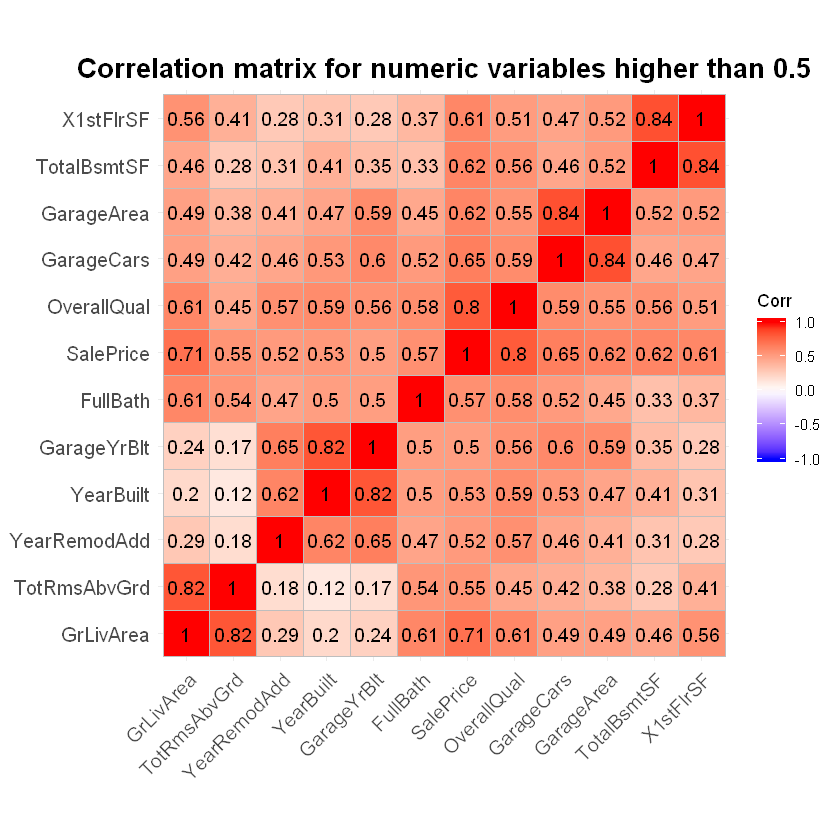

In [13]:
ggcorrplot(CorMatrix, hc.order = TRUE, lab = TRUE) + 
labs(title = "Correlation matrix for numeric variables higher than 0.5") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16))

In [14]:
summary(HousePricesHousePricesDataset$OverallQual)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   5.000   6.000   6.099   7.000  10.000 

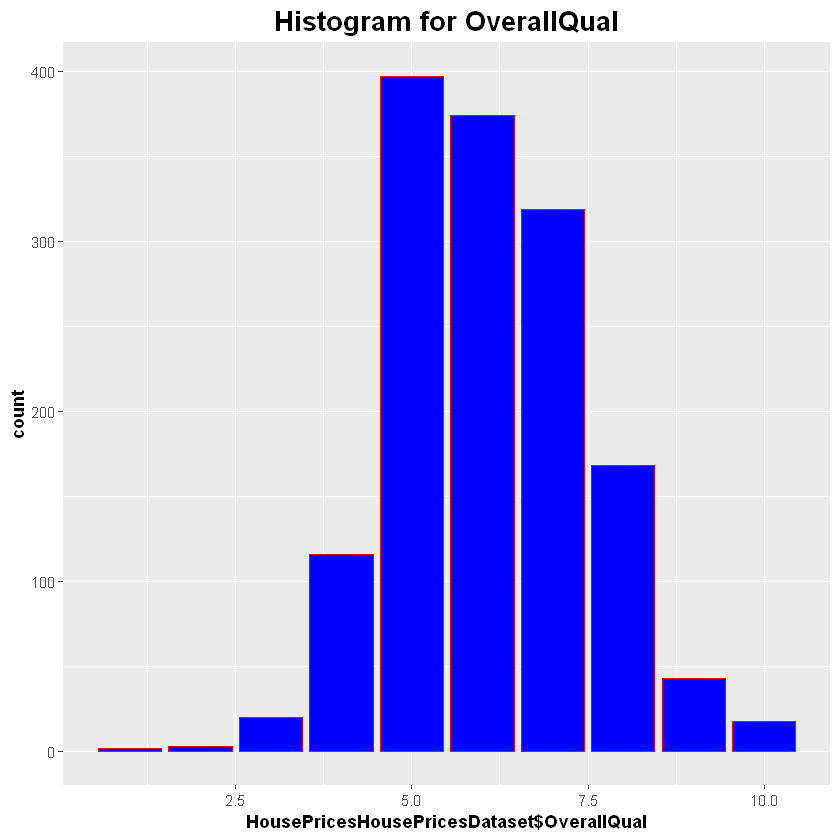

In [15]:
OverallQual <- data.frame(HousePricesHousePricesDataset$OverallQual)
ggplot(OverallQual, aes(HousePricesHousePricesDataset$OverallQual, ..count..)) +
geom_bar(aes(fill = HousePricesHousePricesDataset$OverallQual), position = "dodge", col = "red", fill = 'blue') + 
labs(title = "Histogram for OverallQual") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

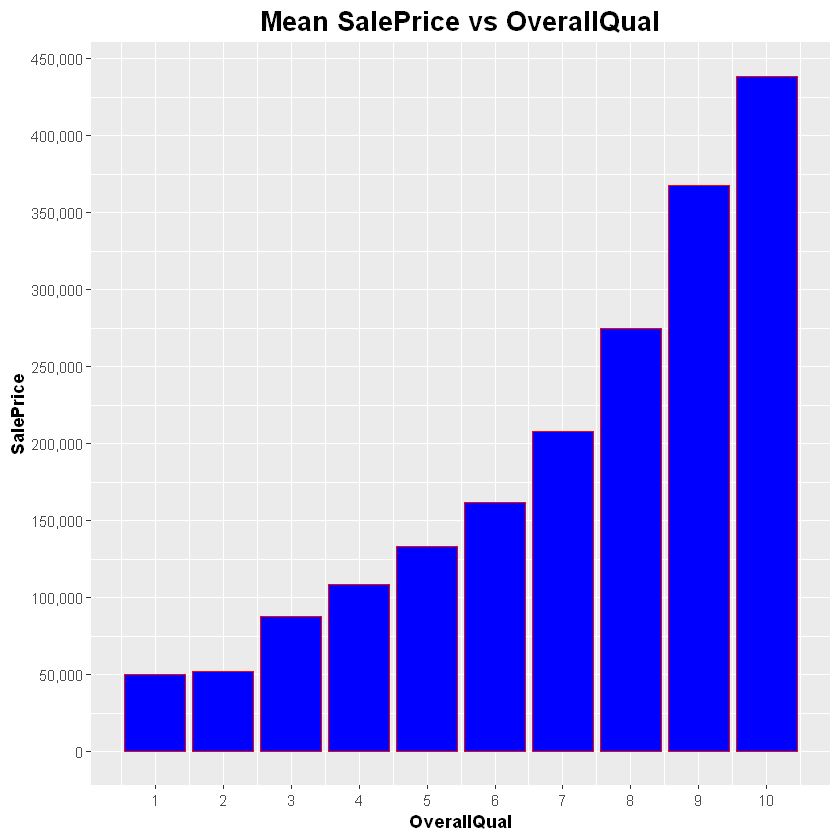

In [16]:
ggplot(HousePricesHousePricesDataset, aes(x = OverallQual, y = SalePrice)) +
stat_summary(fun.y = "mean", geom = "bar", col = "red", fill = 'blue') +
scale_x_continuous(breaks = seq(0, 12, by = 1)) +
scale_y_continuous(breaks = seq(0, 450000, by = 50000), labels = comma) + 
labs(title = "Mean SalePrice vs OverallQual") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [17]:
summary(HousePricesHousePricesDataset$GrLivArea)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    334    1130    1464    1515    1777    5642 

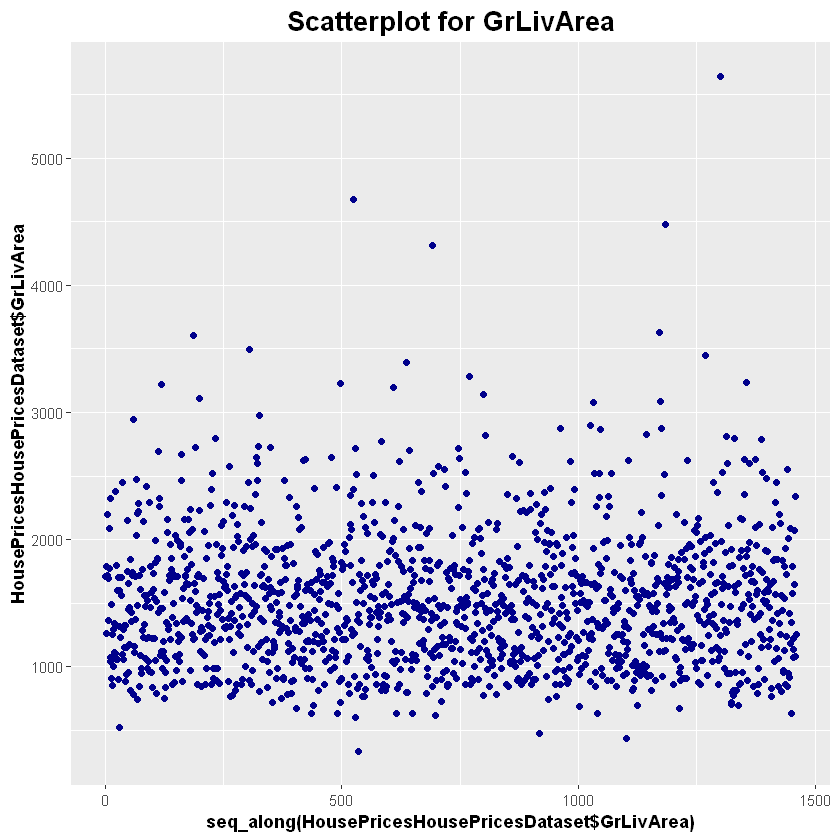

In [18]:
qplot(seq_along(HousePricesHousePricesDataset$GrLivArea), HousePricesHousePricesDataset$GrLivArea) +
  geom_point(color = 'darkblue') + 
  labs(title = "Scatterplot for GrLivArea") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

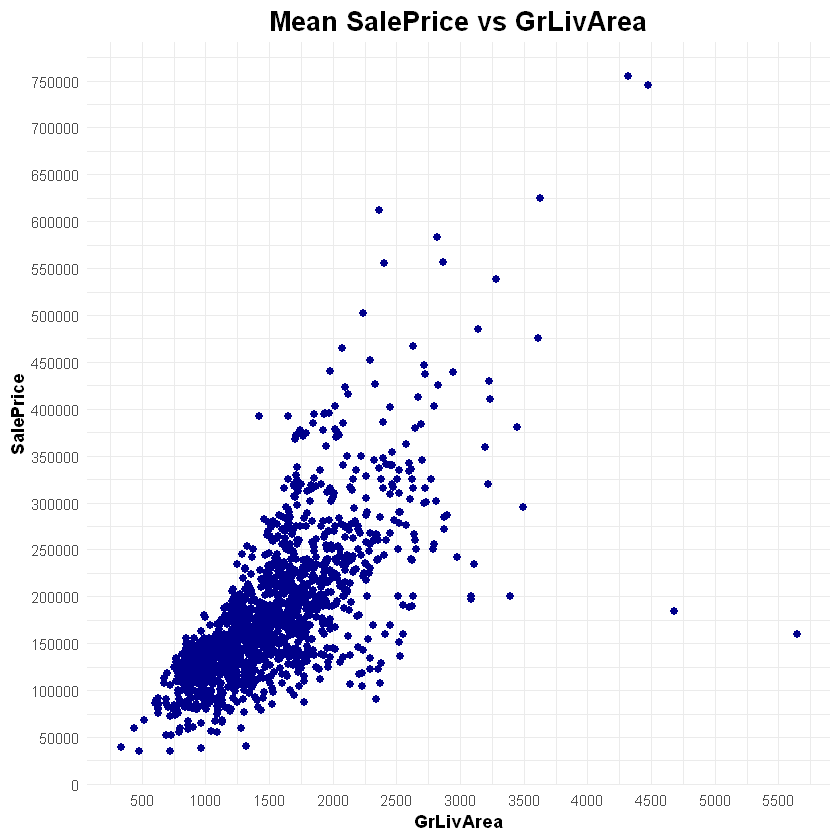

In [19]:
ggplot(HousePricesHousePricesDataset, aes(x = GrLivArea, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 6000, 500)) + 
    labs(title = "Mean SalePrice vs GrLivArea") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [20]:
summary(HousePricesHousePricesDataset$GarageCars)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   2.000   1.767   2.000   4.000 

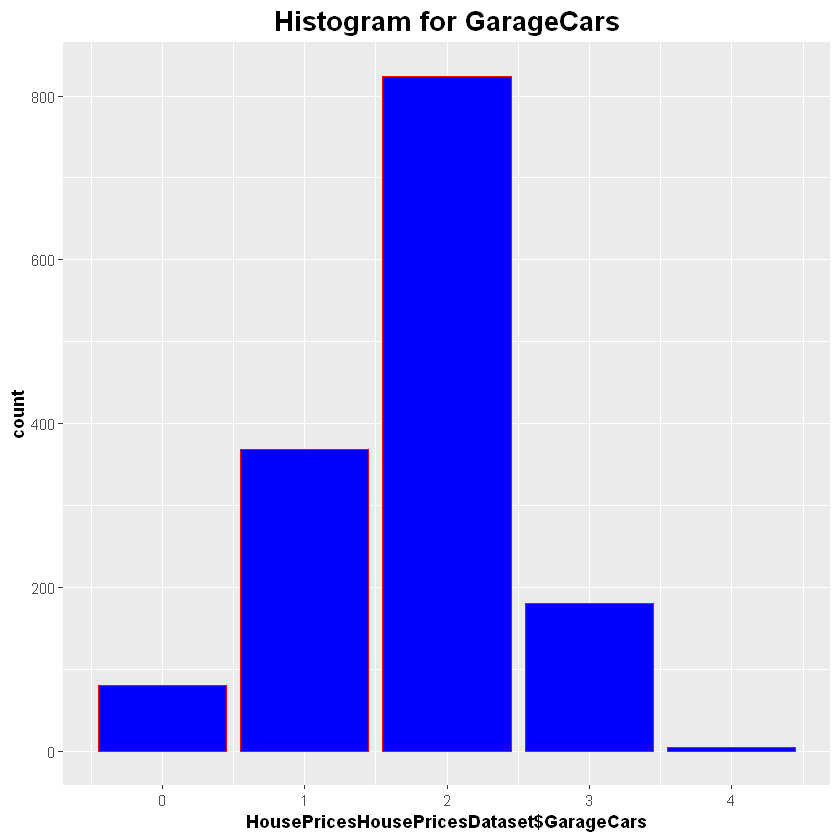

In [21]:
GarageCars <- data.frame(HousePricesHousePricesDataset$GarageCars)
ggplot(GarageCars, aes(HousePricesHousePricesDataset$GarageCars, ..count..)) +
geom_bar(aes(fill = HousePricesHousePricesDataset$GarageCars), position = "dodge", col = "red", fill = 'blue') + 
labs(title = "Histogram for GarageCars") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

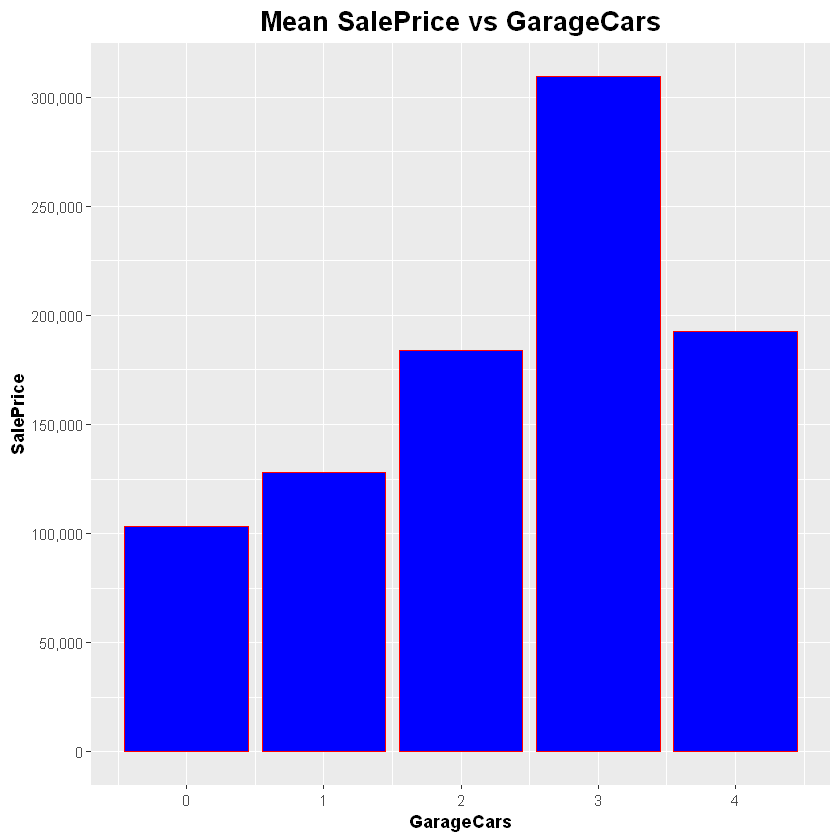

In [22]:
ggplot(HousePricesHousePricesDataset, aes(x = GarageCars, y = SalePrice)) +
stat_summary(fun.y = "mean", geom = "bar", col = "red", fill = 'blue') +
scale_y_continuous(breaks = seq(0, 350000, by = 50000), labels = comma) + 
labs(title = "Mean SalePrice vs GarageCars") +
theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

## Handling missing values

In [23]:
miss <- colSums(is.na(HousePricesPredictorV))
miss

Id    MSSubClass      MSZoning   LotFrontage       LotArea 
            0             0             0           259             0 
       Street         Alley      LotShape   LandContour     Utilities 
            0          1369             0             0             0 
    LotConfig     LandSlope  Neighborhood    Condition1    Condition2 
            0             0             0             0             0 
     BldgType    HouseStyle   OverallQual   OverallCond     YearBuilt 
            0             0             0             0             0 
 YearRemodAdd     RoofStyle      RoofMatl   Exterior1st   Exterior2nd 
            0             0             0             0             0 
   MasVnrType    MasVnrArea     ExterQual     ExterCond    Foundation 
            8             8             0             0             0 
     BsmtQual      BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1 
           37            37            38            37             0 
 BsmtFinType2    BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating 
           38             0             0             0             0 
    HeatingQC    CentralAir    Electrical     X1stFlrSF     X2ndFlrSF 
            0             0             1             0             0 
 LowQualFinSF     GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath 
            0             0             0             0             0 
     HalfBath  BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd 
            0             0             0             0             0 
   Functional    Fireplaces   FireplaceQu    GarageType   GarageYrBlt 
            0             0           690            81            81 
 GarageFinish    GarageCars    GarageArea    GarageQual    GarageCond 
           81             0             0            81            81 
   PavedDrive    WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch 
            0             0             0             0             0 
  ScreenPorch      PoolArea        PoolQC         Fence   MiscFeature 
            0             0          1453          1179          1406 
      MiscVal        MoSold        YrSold      SaleType SaleCondition 
            0             0             0             0             0

In [24]:
# Remove of columns with missing values more than half (1460/2 = 730)
HousePricesPredictorV <- subset(HousePricesPredictorV, select=-c(Alley, PoolQC, Fence, MiscFeature))

### LotFrontage analysis & engineering

Warning message:
"Removed 259 rows containing missing values (geom_point)."

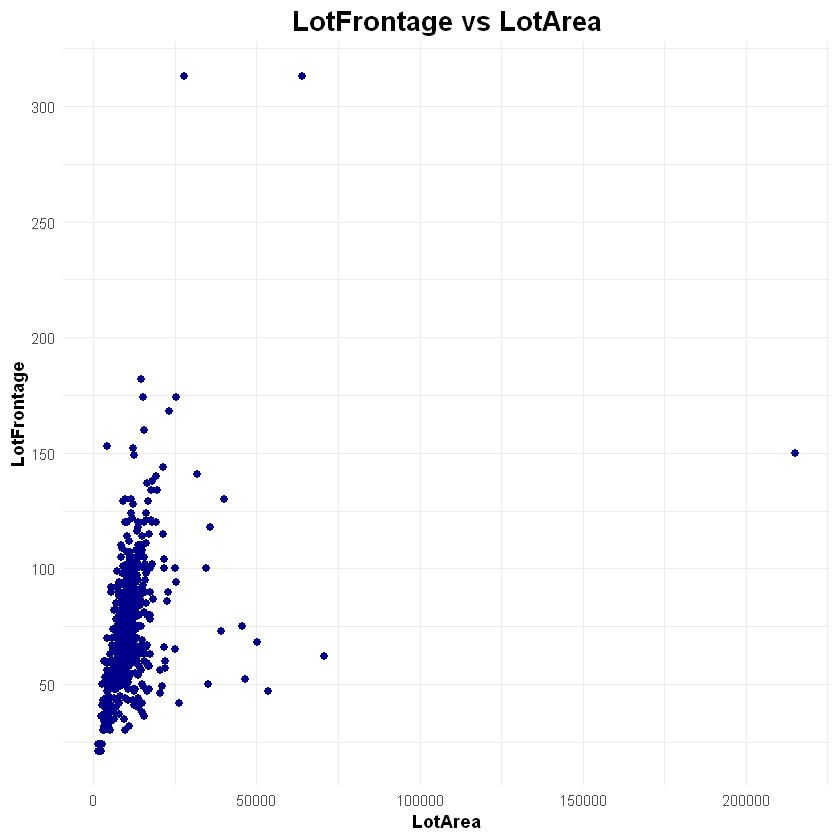

In [25]:
ggplot(HousePricesHousePricesDataset, aes(x = LotArea, y = LotFrontage)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 350, 50)) +
    labs(title = "LotFrontage vs LotArea") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [26]:
dataframePredictorV <- data.frame(HousePricesPredictorV)
dataframePredictorVLF <- dataframePredictorV[, c("Id", "LotFrontage", "LotArea")]
dataframePredictorVLF <- data.frame(dataframePredictorVLF)

In [27]:
head(dataframePredictorVLF, 10)

Id,LotFrontage,LotArea
1,65,8450
2,80,9600
3,68,11250
4,60,9550
5,84,14260
6,85,14115
7,75,10084
8,NA,10382
9,51,6120
10,50,7420


In [28]:
dataframePredictorVLF$LotArea <- as.numeric(dataframePredictorVLF$LotArea)

In [29]:
dataframePredictorNoNa <- dataframePredictorVLF[complete.cases(dataframePredictorVLF), ]
head(dataframePredictorNoNa, 10)

,Id,LotFrontage,LotArea
1,1,65,328
2,2,80,499
3,3,68,703
4,4,60,490
5,5,84,926
6,6,85,916
7,7,75,553
9,9,51,139
10,10,50,223
11,11,70,692


In [30]:
dataframePredictorNa <- dataframePredictorVLF[is.na(dataframePredictorVLF$LotFrontage),]
head(dataframePredictorNa, 10)

,Id,LotFrontage,LotArea
8,8,NA,594
13,13,NA,854
15,15,NA,662
17,17,NA,700
25,25,NA,307
32,32,NA,346
43,43,NA,436
44,44,NA,439
51,51,NA,908
65,65,NA,465


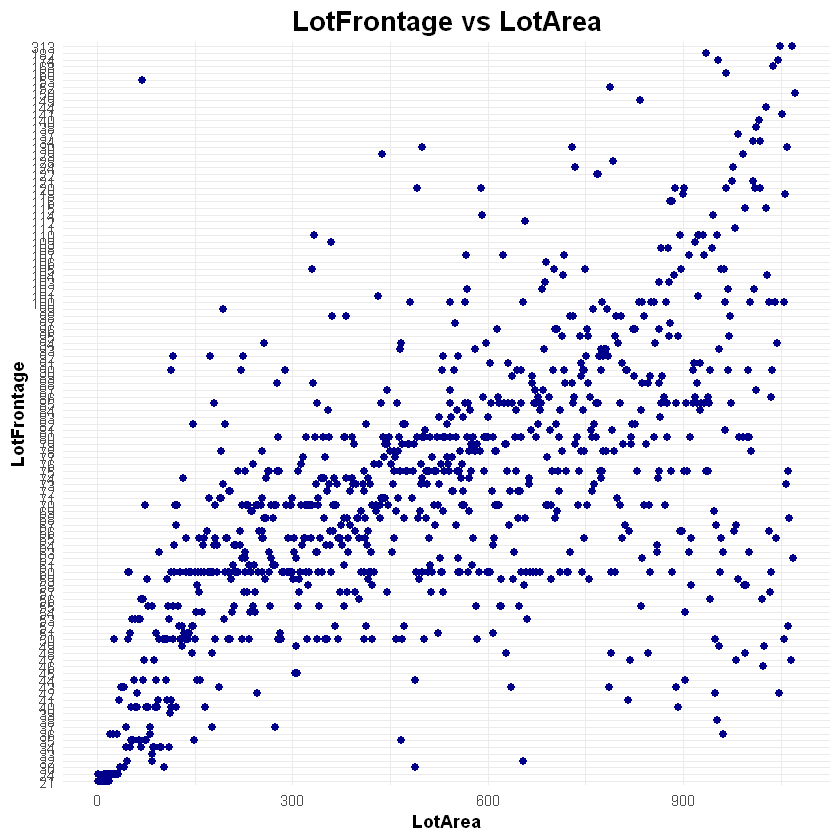

In [31]:
ggplot(dataframePredictorNoNa, aes(x = LotArea, y = LotFrontage)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    labs(title = "LotFrontage vs LotArea") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [32]:
is.factor(dataframePredictorNoNa$LotFrontage)

[1] TRUE

In [33]:
# convert factor to numeric
dataframePredictorNoNa$LotFrontage <- as.numeric(dataframePredictorNoNa$LotFrontage)
is.factor(dataframePredictorNoNa$LotFrontage)

[1] FALSE

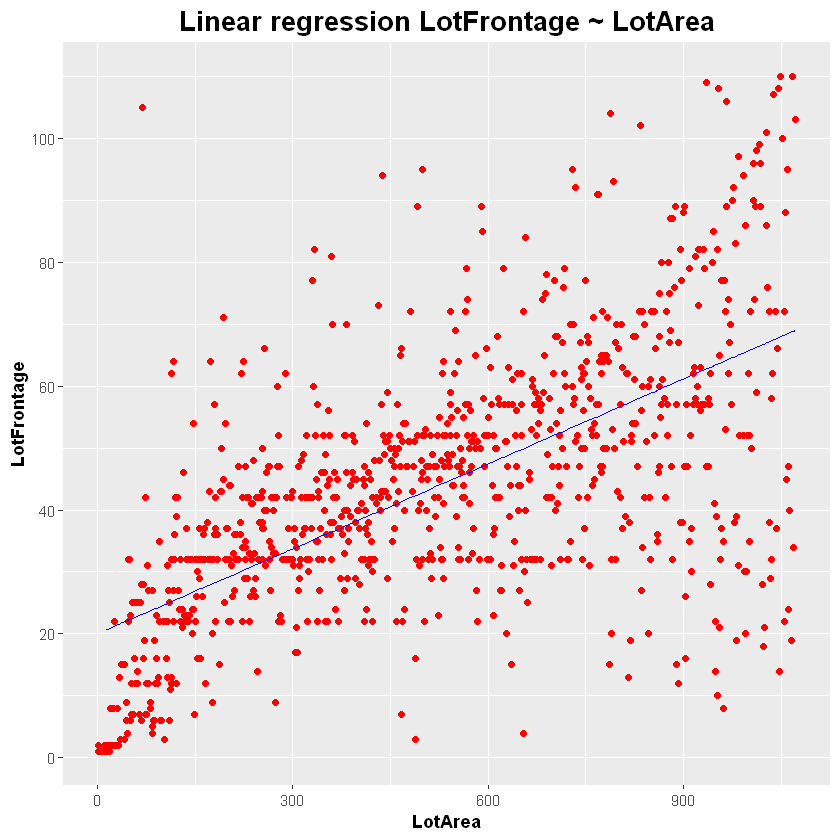

In [34]:
# Fitting Simple Linear Regression
regressor <- lm(formula = LotFrontage ~ LotArea, data = dataframePredictorNoNa)

# Predicitng the Test set results
y_pred <- predict(regressor, newdata = dataframePredictorNa["LotArea"])

# Visualising the Training set results
ggplot() +
  geom_point(aes(x = dataframePredictorNoNa$LotArea, y = dataframePredictorNoNa$LotFrontage),
             colour = 'red') +
  geom_line(aes(x = dataframePredictorNa$LotArea, y = predict(regressor, newdata = dataframePredictorNa["LotArea"])),
            color = 'blue') +
  xlab('LotArea') +
  ylab('LotFrontage') +
  scale_y_continuous(breaks = seq(0, 140, 20)) +
  labs(title = "Linear regression LotFrontage ~ LotArea") +
  theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [35]:
dataframePredictorNa$LotFrontage <- y_pred

In [36]:
head(dataframePredictorNa, 15)

,Id,LotFrontage,LotArea
8,8,47.14280,594
13,13,59.01998,854
15,15,50.24914,662
17,17,51.98503,700
25,25,34.03222,307
32,32,35.81380,346
43,43,39.92513,436
44,44,40.06217,439
51,51,61.48678,908
65,65,41.24989,465


In [37]:
# convert factor to numeric to apply assignment
dataframePredictorV$LotFrontage <- as.numeric(dataframePredictorV$LotFrontage)

In [38]:
class(dataframePredictorV$LotFrontage)

[1] "numeric"

In [39]:
dataframePredictorV[is.na(dataframePredictorV$LotFrontage), "LotFrontage"] <- y_pred

In [40]:
head(dataframePredictorV, 10)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,60,RL,37.0000,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
2,20,RL,52.0000,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
3,60,RL,40.0000,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
4,70,RL,32.0000,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
5,60,RL,56.0000,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal
6,50,RL,57.0000,14115,Pave,IR1,Lvl,AllPub,Inside,...,30,0,320,0,0,700,10,2009,WD,Normal
7,20,RL,47.0000,10084,Pave,Reg,Lvl,AllPub,Inside,...,57,0,0,0,0,0,8,2007,WD,Normal
8,60,RL,47.1428,10382,Pave,IR1,Lvl,AllPub,Corner,...,204,228,0,0,0,350,11,2009,WD,Normal
9,50,RM,23.0000,6120,Pave,Reg,Lvl,AllPub,Inside,...,0,205,0,0,0,0,4,2008,WD,Abnorml
10,190,RL,22.0000,7420,Pave,Reg,Lvl,AllPub,Corner,...,4,0,0,0,0,0,1,2008,WD,Normal


### MSZoning analysis & imputing missing data

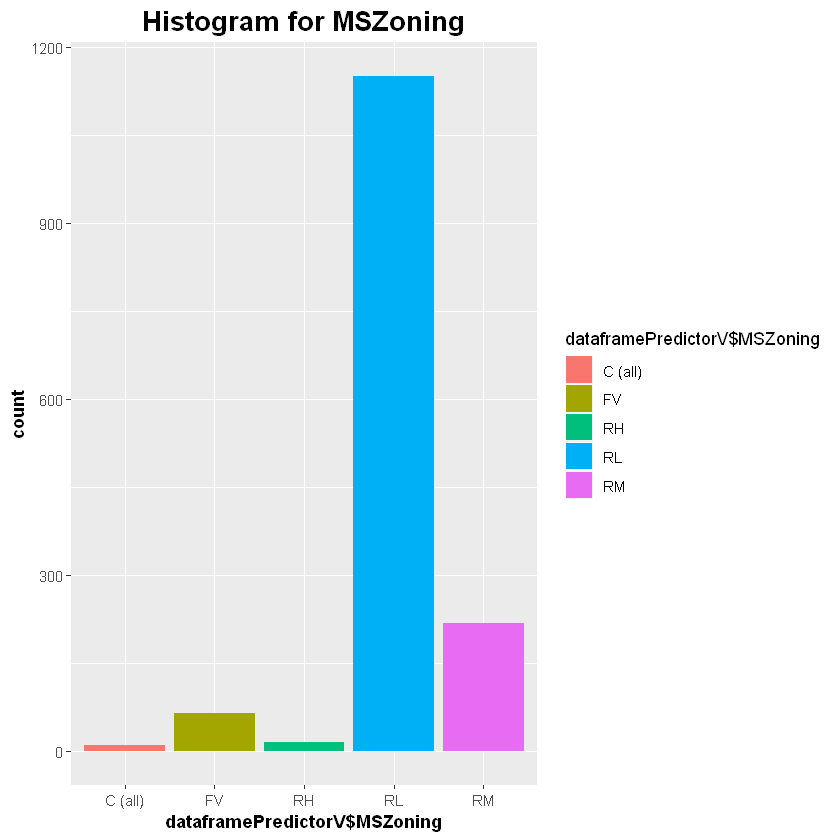

In [41]:
MSZoning <- data.frame(dataframePredictorV$MSZoning)
ggplot(MSZoning, aes(dataframePredictorV$MSZoning, ..count..)) + geom_bar(aes(fill = dataframePredictorV$MSZoning), position = "dodge") +
    labs(title = "Histogram for MSZoning") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [42]:
# Assign "AllPub" to NAs because it is dominating value
dataframePredictorV[is.na(dataframePredictorV$MSZoning), "MSZoning"] <- "RL"

###  Utilities analysis & imputing missing data

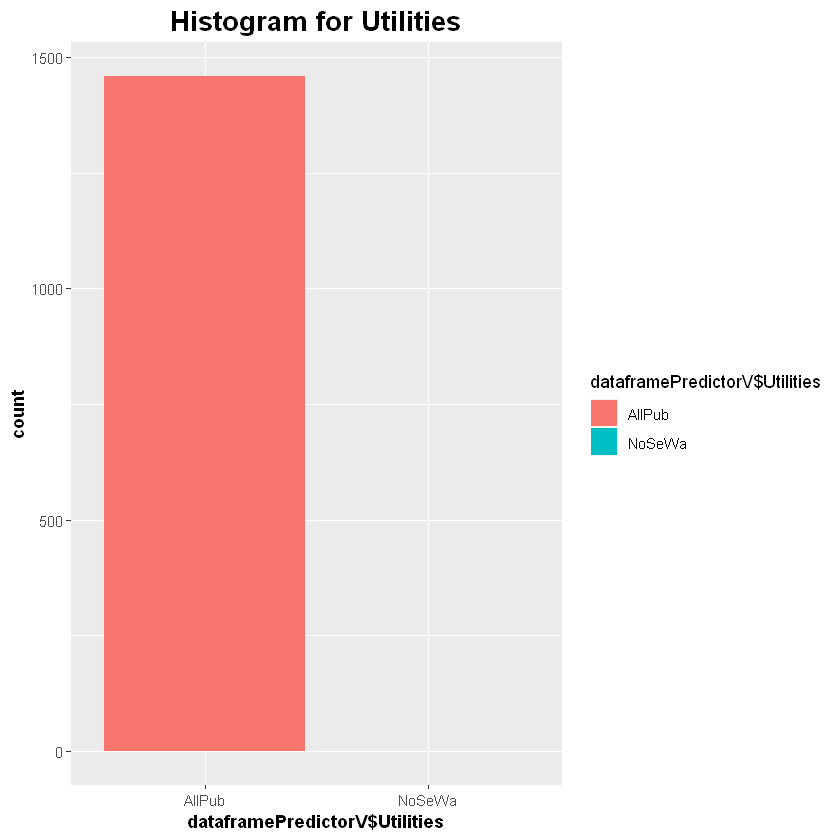

In [43]:
Uti <- data.frame(dataframePredictorV$Utilities)
ggplot(Uti, aes(dataframePredictorV$Utilities, ..count..)) + geom_bar(aes(fill = dataframePredictorV$Utilities), position = "dodge") +
    labs(title = "Histogram for Utilities") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [44]:
# Assign "AllPub" to NAs because it is dominating value
dataframePredictorV[is.na(dataframePredictorV$Utilities), "Utilities"] <- "AllPub"

###  Exterior1st & Exterior2nd analysis & imputing missing data

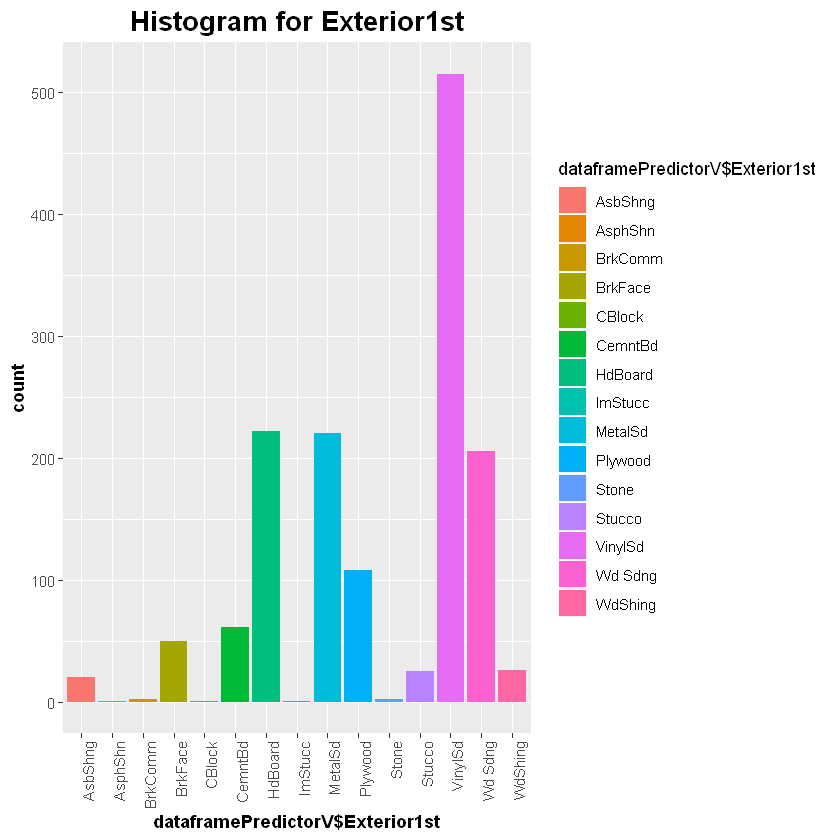

In [45]:
#ggplot(df, aes(Fruit, ..count..)) + geom_bar(aes(fill = Bug), position = "dodge")
Ex1 <- data.frame(dataframePredictorV$Exterior1st)
ggplot(Ex1, aes(dataframePredictorV$Exterior1st, ..count..)) + geom_bar(aes(fill = dataframePredictorV$Exterior1st), position = "dodge") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Histogram for Exterior1st") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

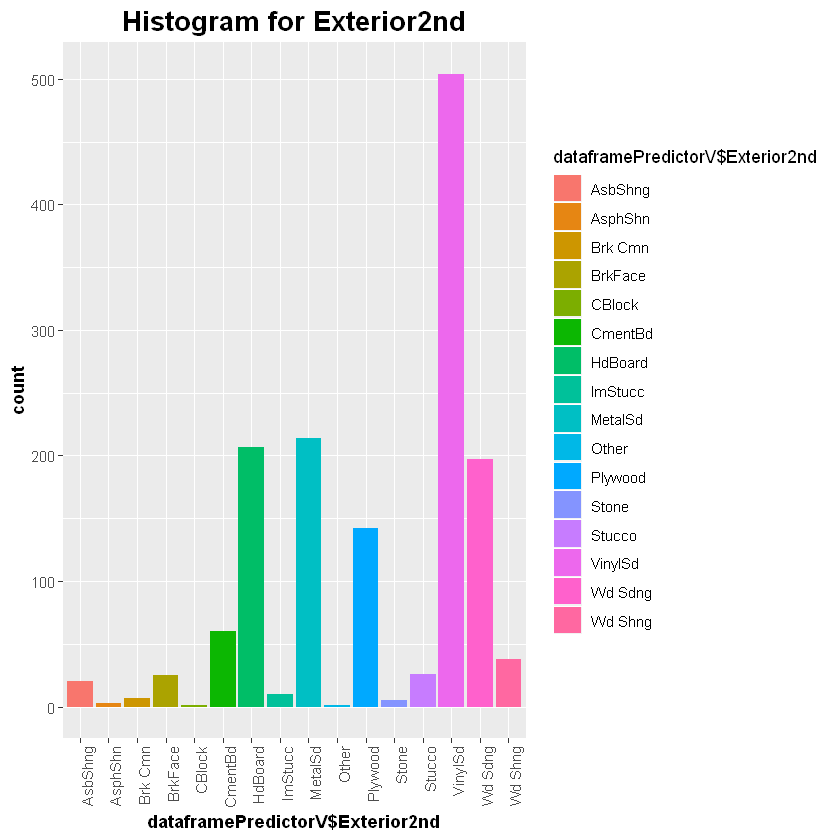

In [46]:
Ex2 <- data.frame(dataframePredictorV$Exterior2nd)
ggplot(Ex2, aes(dataframePredictorV$Exterior2nd, ..count..)) + geom_bar(aes(fill = dataframePredictorV$Exterior2nd), position = "dodge") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    labs(title = "Histogram for Exterior2nd") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [47]:
# Assign for Exterior1st & Exterior2nd "VinylSd" to NAs because it is dominating value
dataframePredictorV[is.na(dataframePredictorV$Exterior1st), "Exterior1st"] <- "VinylSd"
dataframePredictorV[is.na(dataframePredictorV$Exterior2nd), "Exterior2nd"] <- "VinylSd"

###  MasVnrType analysis & imputing missing data

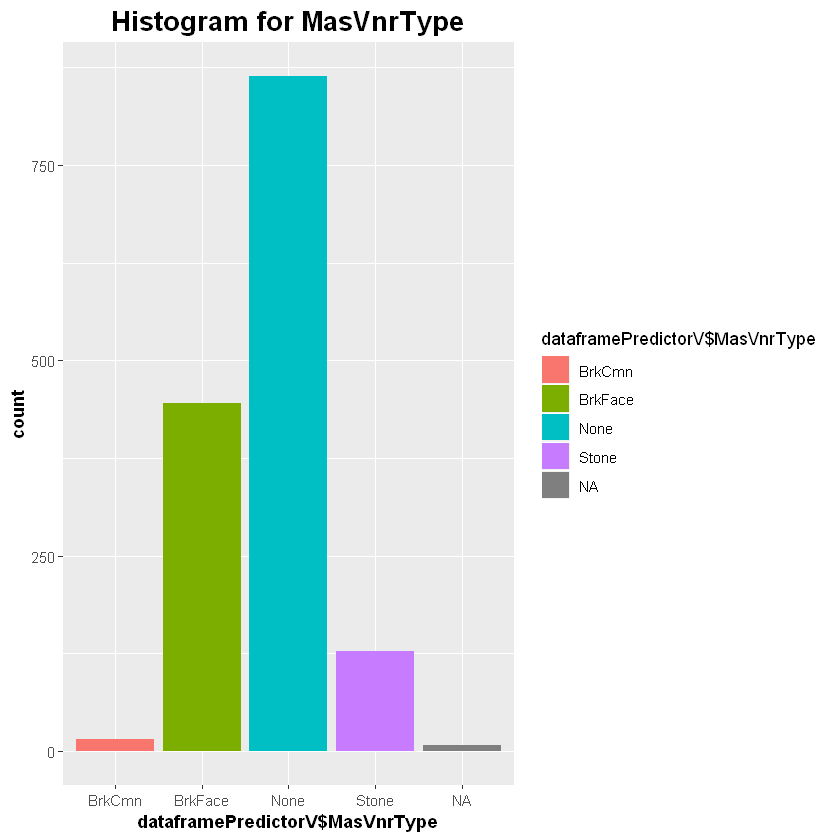

In [48]:
MasVT <- data.frame(dataframePredictorV$MasVnrType)
ggplot(MasVT, aes(dataframePredictorV$MasVnrType, ..count..)) + geom_bar(aes(fill = dataframePredictorV$MasVnrType), position = "dodge") +
    labs(title = "Histogram for MasVnrType") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [49]:
# Assign for MasVnrType "None" to NAs because it is dominating value
dataframePredictorV[is.na(dataframePredictorV$MasVnrType), "MasVnrType"] <- "None"

###  MasVnrArea analysis & imputing missing data

Warning message:
"Removed 8 rows containing missing values (geom_point)."

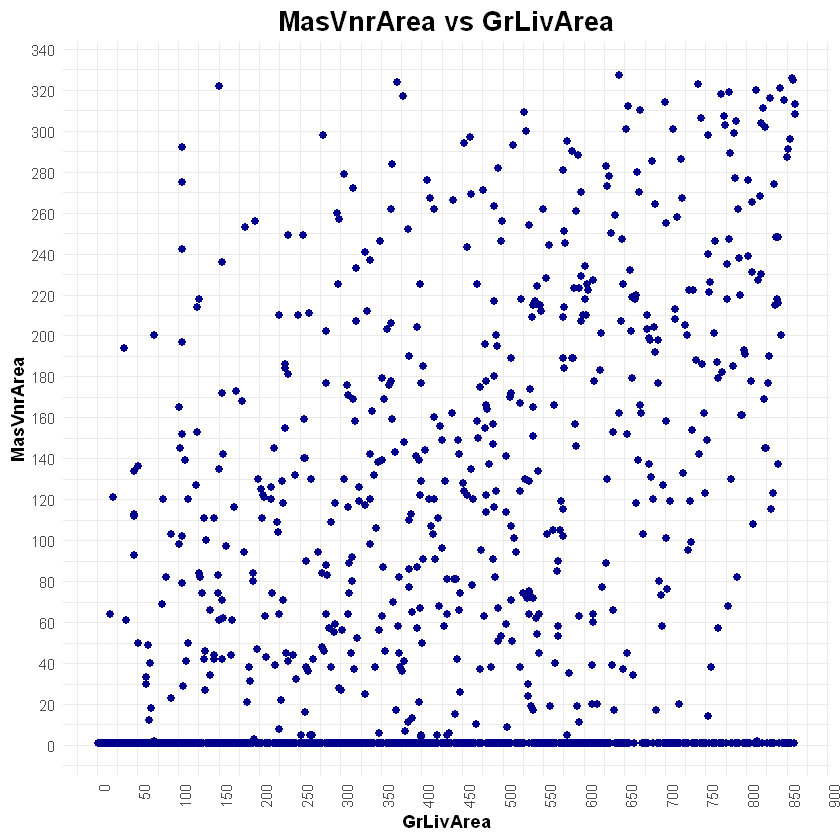

In [50]:
dataframePredictorV$MasVnrArea <- as.numeric(dataframePredictorV$MasVnrArea)
dataframePredictorV$GrLivArea <- as.numeric(dataframePredictorV$GrLivArea)
ggplot(dataframePredictorV, aes(x = GrLivArea, y = MasVnrArea)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 500, 20)) +
    scale_x_continuous(breaks = seq(0, 1500, 50)) +
    labs(title = "MasVnrArea vs GrLivArea") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),
          plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

In [51]:
# Replace NANs of MasVnrArea with mean
mean_MasVnrArea <- mean(dataframePredictorV[complete.cases(dataframePredictorV$MasVnrArea), "MasVnrArea"])
mean_MasVnrArea

[1] 59.19077

In [52]:
dataframePredictorV[is.na(dataframePredictorV$MasVnrArea), "MasVnrArea"] <- mean_MasVnrArea

In [53]:
colSums(is.na(dataframePredictorV))


Id    MSSubClass      MSZoning   LotFrontage       LotArea 
            0             0             0             0             0 
       Street      LotShape   LandContour     Utilities     LotConfig 
            0             0             0             0             0 
    LandSlope  Neighborhood    Condition1    Condition2      BldgType 
            0             0             0             0             0 
   HouseStyle   OverallQual   OverallCond     YearBuilt  YearRemodAdd 
            0             0             0             0             0 
    RoofStyle      RoofMatl   Exterior1st   Exterior2nd    MasVnrType 
            0             0             0             0             0 
   MasVnrArea     ExterQual     ExterCond    Foundation      BsmtQual 
            0             0             0             0            37 
     BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1  BsmtFinType2 
           37            38            37             0            38 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating     HeatingQC 
            0             0             0             0             0 
   CentralAir    Electrical     X1stFlrSF     X2ndFlrSF  LowQualFinSF 
            0             1             0             0             0 
    GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath      HalfBath 
            0             0             0             0             0 
 BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd    Functional 
            0             0             0             0             0 
   Fireplaces   FireplaceQu    GarageType   GarageYrBlt  GarageFinish 
            0           690            81            81            81 
   GarageCars    GarageArea    GarageQual    GarageCond    PavedDrive 
            0             0            81            81             0 
   WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch 
            0             0             0             0             0 
     PoolArea       MiscVal        MoSold        YrSold      SaleType 
            0             0             0             0             0 
SaleCondition 
            0

### Basement variables & imputing missing data

#### Five basement variables have similar number of NAs check if they are the same, if yes it is possible that they not have basement:  
* BsmtQual           37
* BsmtCond          37
* BsmtExposure   38
* BsmtFinType1    37
* BsmtFinType2   38

In [54]:
length(which(is.na(dataframePredictorV$BsmtQual) & is.na(dataframePredictorV$BsmtCond) & is.na(dataframePredictorV$BsmtExposure) & +
             is.na(dataframePredictorV$BsmtFinType1) & is.na(dataframePredictorV$BsmtFinType2)))

[1] 37

In [55]:
#Find the rest NAs and replace them with mode for that variables
dataframePredictorV[!is.na(dataframePredictorV$BsmtFinType1) & (is.na(dataframePredictorV$BsmtCond)|is.na(dataframePredictorV$BsmtQual)|is.na(dataframePredictorV$BsmtExposure)| +
                                is.na(dataframePredictorV$BsmtFinType2)), c('BsmtQual', 'BsmtCond', 'BsmtExposure',
                                                            'BsmtFinType1', 'BsmtFinType2')]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
333,Gd,TA,No,GLQ,NA
949,Gd,TA,NA,Unf,Unf


In [56]:
# Create the mode function.
getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

In [57]:
dataframePredictorV[c(949), c('BsmtExposure')] <- getmode(dataframePredictorV$BsmtExposure)

In [58]:
dataframePredictorV[333, c('BsmtFinType2')] <- getmode(dataframePredictorV$BsmtFinType2)

In [59]:
NoBasementIds <- which(is.na(dataframePredictorV$BsmtQual) & is.na(dataframePredictorV$BsmtCond) & is.na(dataframePredictorV$BsmtExposure) & +
                      is.na(dataframePredictorV$BsmtFinType1) & is.na(dataframePredictorV$BsmtFinType2))

In [60]:
dataframePredictorV$BsmtQual <- as.character(dataframePredictorV$BsmtQual)
dataframePredictorV[NoBasementIds, c('BsmtQual')] <- "NoBasement"

In [61]:
dataframePredictorV$BsmtCond <- as.character(dataframePredictorV$BsmtCond)
dataframePredictorV[NoBasementIds, c('BsmtCond')] <- "NoBasement"

In [62]:
dataframePredictorV$BsmtExposure <- as.character(dataframePredictorV$BsmtExposure)
dataframePredictorV[NoBasementIds, c('BsmtExposure')] <- "NoBasement"

In [63]:
dataframePredictorV$BsmtFinType1 <- as.character(dataframePredictorV$BsmtFinType1)
dataframePredictorV[NoBasementIds, c('BsmtFinType1')] <- "NoBasement"

In [64]:
dataframePredictorV$BsmtFinType2 <- as.character(dataframePredictorV$BsmtFinType2)
dataframePredictorV[NoBasementIds, c('BsmtFinType2')] <- "NoBasement"

### Below are variables with single NAs and are replaced by modes

In [65]:
dataframePredictorV[is.na(dataframePredictorV$BsmtFinSF1), c('BsmtFinSF1')] <- getmode(dataframePredictorV$BsmtFinSF1)

In [66]:
dataframePredictorV[is.na(dataframePredictorV$BsmtFinSF2), c('BsmtFinSF2')] <- getmode(dataframePredictorV$BsmtFinSF2)

In [67]:
dataframePredictorV[is.na(dataframePredictorV$BsmtUnfSF), c('BsmtUnfSF')] <- getmode(dataframePredictorV$BsmtUnfSF)

In [68]:
dataframePredictorV[is.na(dataframePredictorV$TotalBsmtSF), c('TotalBsmtSF')] <- getmode(dataframePredictorV$TotalBsmtSF)

In [69]:
dataframePredictorV[is.na(dataframePredictorV$Electrical), c('Electrical')] <- getmode(dataframePredictorV$Electrical)

In [70]:
dataframePredictorV[is.na(dataframePredictorV$BsmtFullBath), c('BsmtFullBath')] <- getmode(dataframePredictorV$BsmtFullBath)

In [71]:
dataframePredictorV[is.na(dataframePredictorV$BsmtHalfBath), c('BsmtHalfBath')] <- getmode(dataframePredictorV$BsmtHalfBath)

In [72]:
dataframePredictorV[is.na(dataframePredictorV$KitchenQual), c('KitchenQual')] <- getmode(dataframePredictorV$KitchenQual)

In [73]:
dataframePredictorV[is.na(dataframePredictorV$Functional), c('Functional')] <- getmode(dataframePredictorV$Functional)

In [74]:
dataframePredictorV[is.na(dataframePredictorV$GarageArea), c('GarageArea')] <- getmode(dataframePredictorV$GarageArea)

In [75]:
dataframePredictorV[is.na(dataframePredictorV$GarageCars), c('GarageCars')] <- getmode(dataframePredictorV$GarageCars)

In [76]:
dataframePredictorV[is.na(dataframePredictorV$SaleType), c('SaleType')] <- getmode(dataframePredictorV$SaleType)

### Analyse garage variables

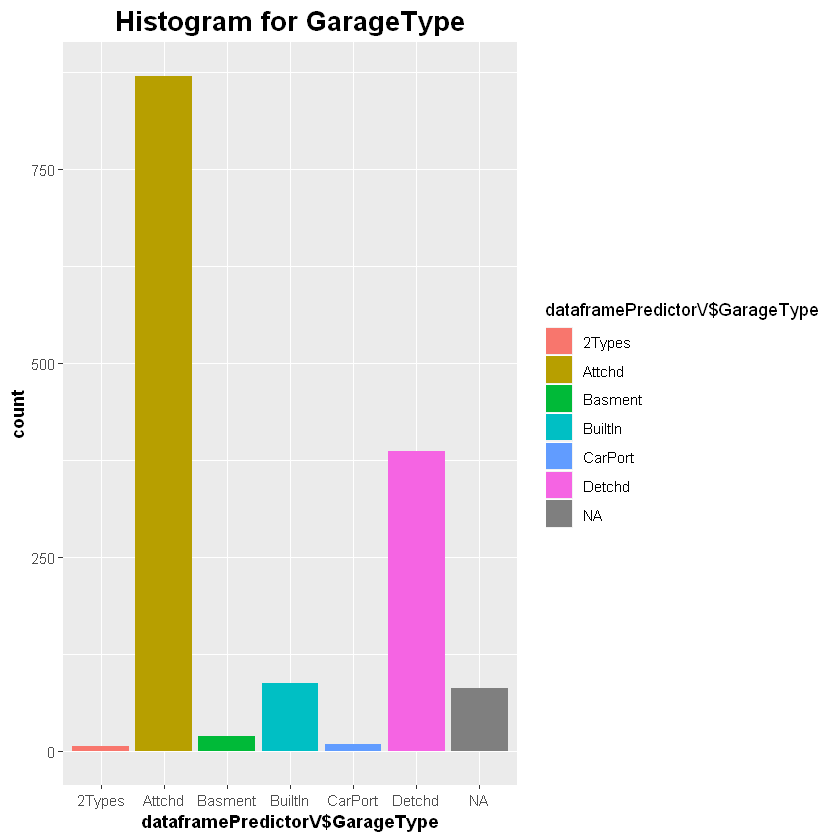

In [77]:
GarageType <- data.frame(dataframePredictorV$GarageType)
ggplot(GarageType, aes(dataframePredictorV$GarageType, ..count..)) + geom_bar(aes(fill = dataframePredictorV$GarageType), position = "dodge") +
    labs(title = "Histogram for GarageType") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

### Five garage variables have similar number of NAs check if they are the same, if yes it is possible that they not have garage:  
* GarageType      81
* GarageYrBlt      81
* GarageFinish    81
* GarageQual      81
* GarageCond     81

In [78]:
length(which(is.na(dataframePredictorV$GarageType) & is.na(dataframePredictorV$GarageYrBlt) & is.na(dataframePredictorV$GarageFinish) & +
             is.na(dataframePredictorV$GarageQual) & is.na(dataframePredictorV$GarageCond)))

[1] 81

Warning message:
"Removed 81 rows containing missing values (geom_point)."Warning message:
"Removed 81 rows containing missing values (geom_point)."

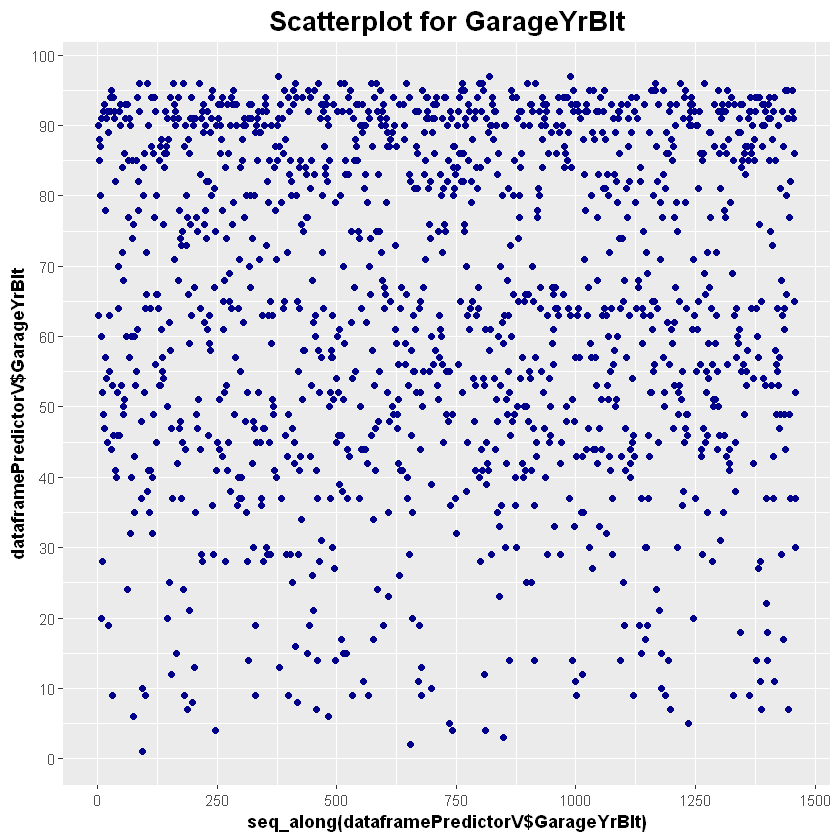

In [79]:
dataframePredictorV$GarageYrBlt <- as.numeric(dataframePredictorV$GarageYrBlt)
qplot(seq_along(dataframePredictorV$GarageYrBlt), dataframePredictorV$GarageYrBlt) +
    scale_y_continuous(breaks = seq(0, 120, 10)) +
    scale_x_continuous(breaks = seq(0, 1500, 250)) +
    geom_point(color = 'darkblue') + 
    labs(title = "Scatterplot for GarageYrBlt") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [80]:
NoGarageIds <- which(is.na(dataframePredictorV$GarageType) & is.na(dataframePredictorV$GarageYrBlt) & is.na(dataframePredictorV$GarageFinish) & +
                    is.na(dataframePredictorV$GarageQual) & is.na(dataframePredictorV$GarageCond))

In [81]:
dataframePredictorV$GarageType <- as.character(dataframePredictorV$GarageType)
dataframePredictorV[NoGarageIds, c('GarageType')] <- "NoGarage"

In [82]:
dataframePredictorV$GarageYrBlt <- as.numeric(dataframePredictorV$GarageYrBlt)
dataframePredictorV[NoGarageIds, c('GarageYrBlt')] <- 0

In [83]:
dataframePredictorV$GarageFinish <- as.character(dataframePredictorV$GarageFinish)
dataframePredictorV[NoGarageIds, c('GarageFinish')] <- "NoGarage"

In [84]:
dataframePredictorV$GarageQual <- as.character(dataframePredictorV$GarageQual)
dataframePredictorV[NoGarageIds, c('GarageQual')] <- "NoGarage"

In [85]:
dataframePredictorV$GarageCond <- as.character(dataframePredictorV$GarageCond)
dataframePredictorV[NoGarageIds, c('GarageCond')] <- "NoGarage"

###  FireplaceQu & imputing missing data

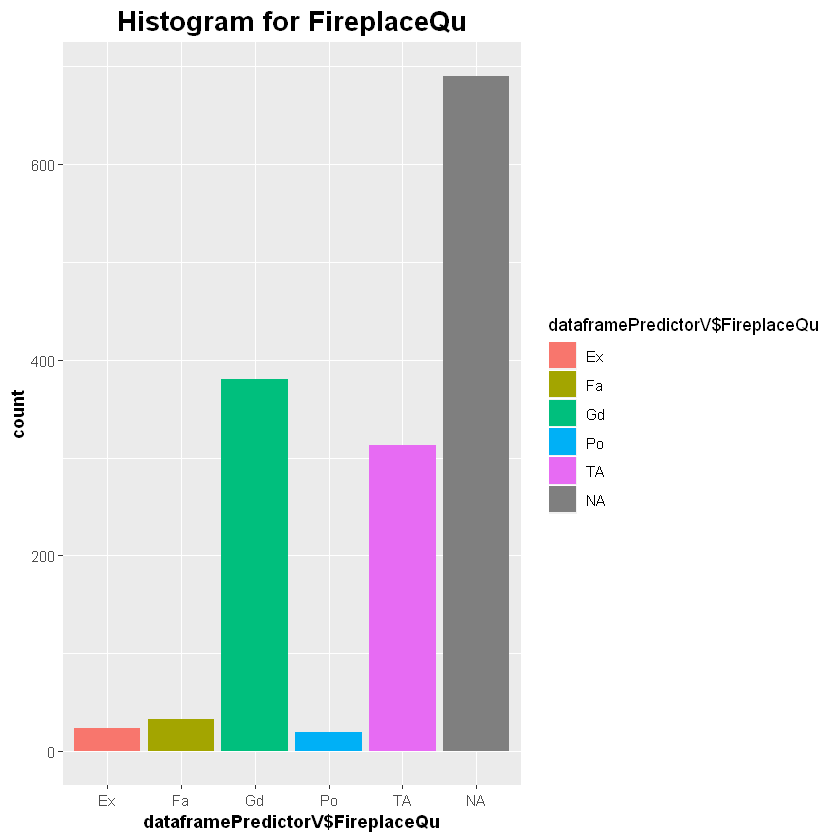

In [86]:
FireplaceQu <- data.frame(dataframePredictorV$FireplaceQu)
ggplot(FireplaceQu, aes(dataframePredictorV$FireplaceQu, ..count..)) + geom_bar(aes(fill = dataframePredictorV$FireplaceQu), position = "dodge") +
    labs(title = "Histogram for FireplaceQu") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

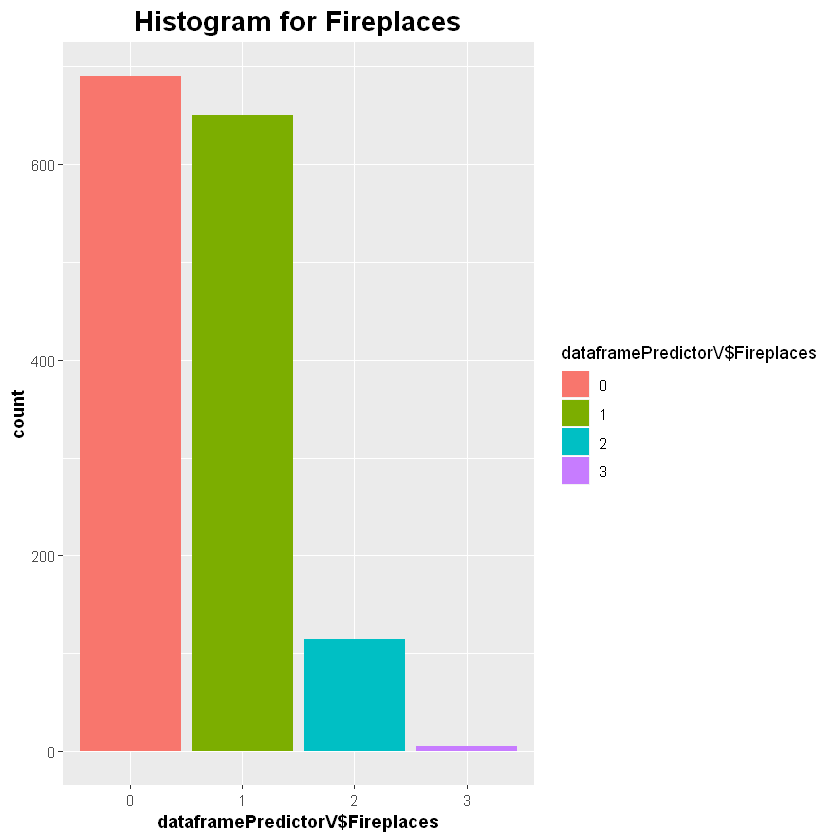

In [87]:
ggplot(FireplaceQu, aes(dataframePredictorV$Fireplaces, ..count..)) + geom_bar(aes(fill = dataframePredictorV$Fireplaces), position = "dodge") +
    labs(title = "Histogram for Fireplaces") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

In [88]:
# Check if number of NAs in  FireplaceQu is equal with number of houses that have not fireplace,
# if yes replace NAs with 'NoFireplace'
sum(dataframePredictorV$Fireplaces == 0) == length(dataframePredictorV[is.na(dataframePredictorV$FireplaceQu), "FireplaceQu"])

[1] TRUE

In [89]:
dataframePredictorV$FireplaceQu <- as.character(dataframePredictorV$FireplaceQu)
dataframePredictorV[is.na(dataframePredictorV$FireplaceQu), c('FireplaceQu')] <- 'NoFireplace'

In [90]:
# Checkif there is no missing values
miss2 <- colSums(is.na(dataframePredictorV))
miss2

Id    MSSubClass      MSZoning   LotFrontage       LotArea 
            0             0             0             0             0 
       Street      LotShape   LandContour     Utilities     LotConfig 
            0             0             0             0             0 
    LandSlope  Neighborhood    Condition1    Condition2      BldgType 
            0             0             0             0             0 
   HouseStyle   OverallQual   OverallCond     YearBuilt  YearRemodAdd 
            0             0             0             0             0 
    RoofStyle      RoofMatl   Exterior1st   Exterior2nd    MasVnrType 
            0             0             0             0             0 
   MasVnrArea     ExterQual     ExterCond    Foundation      BsmtQual 
            0             0             0             0             0 
     BsmtCond  BsmtExposure  BsmtFinType1    BsmtFinSF1  BsmtFinType2 
            0             0             0             0             0 
   BsmtFinSF2     BsmtUnfSF   TotalBsmtSF       Heating     HeatingQC 
            0             0             0             0             0 
   CentralAir    Electrical     X1stFlrSF     X2ndFlrSF  LowQualFinSF 
            0             0             0             0             0 
    GrLivArea  BsmtFullBath  BsmtHalfBath      FullBath      HalfBath 
            0             0             0             0             0 
 BedroomAbvGr  KitchenAbvGr   KitchenQual  TotRmsAbvGrd    Functional 
            0             0             0             0             0 
   Fireplaces   FireplaceQu    GarageType   GarageYrBlt  GarageFinish 
            0             0             0             0             0 
   GarageCars    GarageArea    GarageQual    GarageCond    PavedDrive 
            0             0             0             0             0 
   WoodDeckSF   OpenPorchSF EnclosedPorch    X3SsnPorch   ScreenPorch 
            0             0             0             0             0 
     PoolArea       MiscVal        MoSold        YrSold      SaleType 
            0             0             0             0             0 
SaleCondition 
            0

## Analysing the most important categorical variables

In [91]:
# Because the number of categorical variables test are performed separetly for selected groups of them
#aov.ex5 = aov(SalePrice ~ (GarageType+GarageFinish), HousePricesDataset)
#DF_categ <- cbind(HousePricesDataset[categ], HousePricesDataset$SalePrice)
#aov.ex5 = aov(HousePricesDataset$SalePrice ~ . - MSZoning - Street - Alley- LotShape - LandContour, DF_categ)
dataframePredictorV_categ <- which(unlist(lapply(dataframePredictorV, is.factor)))
DF_categ <- cbind(head(dataframePredictorV[names(dataframePredictorV_categ)], 1460), HousePricesDataset$SalePrice[1:1460])
aov.test1 <- aov(HousePricesDataset$SalePrice[1:1460] ~ MSSubClass + MSZoning + Street + LotShape +
                LandContour + Utilities + LotConfig + LandSlope, DF_categ)
summary(aov.test1)

ERROR: Error in cbind(head(dataframePredictorV[names(dataframePredictorV_categ)], : nie znaleziono obiektu 'HousePricesDataset'


In [ ]:
aov.test2 = aov(HousePricesDataset$SalePrice[1:1460] ~ Condition1 + Condition2 + BldgType + HouseStyle +
                OverallQual + OverallCond + RoofStyle + RoofMatl, DF_categ)
summary(aov.test2)

In [ ]:
aov.test3 = aov(HousePricesDataset$SalePrice[1:1460] ~ Exterior1st + Exterior2nd + MasVnrType + ExterQual +
                ExterCond + Foundation + Heating + HeatingQC, DF_categ)
summary(aov.test3)

In [ ]:
aov.test4 = aov(HousePricesDataset$SalePrice[1:1460] ~ CentralAir + Electrical + BsmtFullBath + BsmtHalfBath +
                FullBath + HalfBath + BedroomAbvGr + KitchenAbvGr, DF_categ)
summary(aov.test4)

In [ ]:
aov.test5 = aov(HousePricesDataset$SalePrice[1:1460] ~ KitchenQual + TotRmsAbvGrd + Functional + Fireplaces +
                GarageCars + PavedDrive + X3SsnPorch + PoolArea, DF_categ)
summary(aov.test5)

In [ ]:
aov.test6 = aov(HousePricesDataset$SalePrice[1:1460] ~ MiscVal + MoSold + YrSold + SaleType + SaleCondition, DF_categ)
summary(aov.test6)

In [ ]:
ggplot(HousePricesDataset, aes(x = LandSlope, y = SalePrice)) + 
    geom_boxplot(outlier.colour = "blue", outlier.shape = 8, outlier.size = 4) +
    labs(title = "Boxplot for LandSlope") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold")) +
    scale_y_continuous(breaks = seq(0, 700000, 100000), labels = comma)

In [92]:
ggplot(HousePricesDataset, aes(x = LotConfig, y = SalePrice)) + 
    geom_boxplot(outlier.colour = "blue", outlier.shape = 8, outlier.size = 4) +
    labs(title = "Boxplot for LotConfig") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold")) +
    scale_y_continuous(breaks = seq(0, 700000, 100000), labels = comma)

ERROR: Error in ggplot(HousePricesDataset, aes(x = LotConfig, y = SalePrice)): nie znaleziono obiektu 'HousePricesDataset'


In [ ]:
ggplot(HousePricesDataset, aes(x = OverallCond, y = SalePrice, group = OverallCond)) + 
    geom_boxplot(outlier.colour = "blue", outlier.shape = 8, outlier.size = 4) +
    labs(title = "Boxplot for OverallCond") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold")) +
    scale_y_continuous(breaks = seq(0, 700000, 100000), labels = comma) +
    scale_x_continuous(breaks = seq(1, 10, 1))

In [ ]:
ggplot(HousePricesDataset, aes(x = MoSold, y = SalePrice, group = MoSold)) + 
    geom_boxplot(outlier.colour = "blue", outlier.shape = 8, outlier.size = 4) +
    labs(title = "Boxplot for OverallCond") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold")) +
    scale_y_continuous(breaks = seq(0, 700000, 100000), labels = comma) +
    scale_x_continuous(breaks = seq(1, 12, 1))

## Removal of less important variables

### Label encoding/factorizing the remaining character variables

In [93]:
str(dataframePredictorV)

'data.frame':	1460 obs. of  76 variables:
 $ Id           : Factor w/ 1460 levels "   1","   2",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : Factor w/ 15 levels " 20"," 30"," 40",..: 6 1 6 7 6 5 1 6 5 15 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : num  37 52 40 32 56 ...
 $ LotArea      : Factor w/ 1073 levels "  1300","  1477",..: 328 499 703 490 926 916 553 594 139 223 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..: 6 25 6 7 14 12

In [94]:
# Convert wrongly clasified factors to numeric
dataframePredictorV$LotArea <- as.numeric(dataframePredictorV$LotArea)
dataframePredictorV$YearBuilt <- as.numeric(dataframePredictorV$YearBuilt)
dataframePredictorV$YearRemodAdd <- as.numeric(dataframePredictorV$YearRemodAdd)
dataframePredictorV$BsmtFinSF1 <- as.numeric(dataframePredictorV$BsmtFinSF1)
dataframePredictorV$BsmtFinSF2 <- as.numeric(dataframePredictorV$BsmtFinSF2)
dataframePredictorV$BsmtUnfSF  <- as.numeric(dataframePredictorV$BsmtUnfSF )
dataframePredictorV$TotalBsmtSF <- as.numeric(dataframePredictorV$TotalBsmtSF)
dataframePredictorV$X1stFlrSF <- as.numeric(dataframePredictorV$X1stFlrSF)
dataframePredictorV$X2ndFlrSF <- as.numeric(dataframePredictorV$X2ndFlrSF)
dataframePredictorV$GarageArea <- as.numeric(dataframePredictorV$GarageArea)
dataframePredictorV$WoodDeckSF <- as.numeric(dataframePredictorV$WoodDeckSF)
dataframePredictorV$OpenPorchSF <- as.numeric(dataframePredictorV$OpenPorchSF)
dataframePredictorV$EnclosedPorch <- as.numeric(dataframePredictorV$EnclosedPorch)
dataframePredictorV$ScreenPorch <- as.numeric(dataframePredictorV$ScreenPorch)
dataframePredictorV$OverallQual <- as.numeric(dataframePredictorV$OverallQual)

In [95]:
# Convert characters to factor
dataframePredictorV$BsmtQual <- as.factor(dataframePredictorV$BsmtQual)
dataframePredictorV$BsmtCond <- as.factor(dataframePredictorV$BsmtCond)
dataframePredictorV$BsmtExposure <- as.factor(dataframePredictorV$BsmtExposure)
dataframePredictorV$BsmtFinType1 <- as.factor(dataframePredictorV$BsmtFinType1)
dataframePredictorV$BsmtFinType2 <- as.factor(dataframePredictorV$BsmtFinType2)
dataframePredictorV$FireplaceQu <- as.factor(dataframePredictorV$FireplaceQu)
dataframePredictorV$GarageType <- as.factor(dataframePredictorV$GarageType)
dataframePredictorV$GarageFinish <- as.factor(dataframePredictorV$GarageFinish)
dataframePredictorV$GarageQual <- as.factor(dataframePredictorV$GarageQual)
dataframePredictorV$GarageCond <- as.factor(dataframePredictorV$GarageCond)
dataframePredictorV$KitchenQual <- as.factor(dataframePredictorV$KitchenQual)

In [96]:
str(dataframePredictorV)

'data.frame':	1460 obs. of  76 variables:
 $ Id           : Factor w/ 1460 levels "   1","   2",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : Factor w/ 15 levels " 20"," 30"," 40",..: 6 1 6 7 6 5 1 6 5 15 ...
 $ MSZoning     : Factor w/ 5 levels "C (all)","FV",..: 4 4 4 4 4 4 4 4 5 4 ...
 $ LotFrontage  : num  37 52 40 32 56 ...
 $ LotArea      : num  328 499 703 490 926 916 553 594 139 223 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 2 levels "AllPub","NoSeWa": 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..: 6 25 6 7 14 12 21 17 18 4 ...
 $ Condition1   : Facto

In [97]:
head(dataframePredictorV, 10)

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,60,RL,37.0000,328,Pave,Reg,Lvl,AllPub,Inside,...,50,1,0,1,0,0,2,2008,WD,Normal
2,20,RL,52.0000,499,Pave,Reg,Lvl,AllPub,FR2,...,1,1,0,1,0,0,5,2007,WD,Normal
3,60,RL,40.0000,703,Pave,IR1,Lvl,AllPub,Inside,...,31,1,0,1,0,0,9,2008,WD,Normal
4,70,RL,32.0000,490,Pave,IR1,Lvl,AllPub,Corner,...,25,109,0,1,0,0,2,2006,WD,Abnorml
5,60,RL,56.0000,926,Pave,IR1,Lvl,AllPub,FR2,...,71,1,0,1,0,0,12,2008,WD,Normal
6,50,RL,57.0000,916,Pave,IR1,Lvl,AllPub,Inside,...,21,1,320,1,0,700,10,2009,WD,Normal
7,20,RL,47.0000,553,Pave,Reg,Lvl,AllPub,Inside,...,46,1,0,1,0,0,8,2007,WD,Normal
8,60,RL,47.1428,594,Pave,IR1,Lvl,AllPub,Corner,...,157,95,0,1,0,350,11,2009,WD,Normal
9,50,RM,23.0000,139,Pave,Reg,Lvl,AllPub,Inside,...,1,84,0,1,0,0,4,2008,WD,Abnorml
10,190,RL,22.0000,223,Pave,Reg,Lvl,AllPub,Corner,...,2,1,0,1,0,0,1,2008,WD,Normal


In [98]:
# drop Id column
dataframePredictorV = subset(dataframePredictorV, select = -c(Id))

In [99]:
dataframePredictorV_VarImp <- dataframePredictorV

In [100]:
# add SalePrice for training
dataframePredictorV_VarImp <- cbind(dataframePredictorV_VarImp, HousePricesTargetV)

In [101]:
head(dataframePredictorV_VarImp, 10)

MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,X3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HousePricesTargetV
60,RL,37.0000,328,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,0,1,0,0,2,2008,WD,Normal,208500
20,RL,52.0000,499,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,1,0,1,0,0,5,2007,WD,Normal,181500
60,RL,40.0000,703,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,1,0,1,0,0,9,2008,WD,Normal,223500
70,RL,32.0000,490,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,109,0,1,0,0,2,2006,WD,Abnorml,140000
60,RL,56.0000,926,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,1,0,1,0,0,12,2008,WD,Normal,250000
50,RL,57.0000,916,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,1,320,1,0,700,10,2009,WD,Normal,143000
20,RL,47.0000,553,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,1,0,1,0,0,8,2007,WD,Normal,307000
60,RL,47.1428,594,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,95,0,1,0,350,11,2009,WD,Normal,200000
50,RM,23.0000,139,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,84,0,1,0,0,4,2008,WD,Abnorml,129900
190,RL,22.0000,223,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,1,0,1,0,0,1,2008,WD,Normal,118000


In [102]:
dim(dataframePredictorV_VarImp)

[1] 1460   76

In [103]:
# Checkif there is no missing values
miss3 = colSums(is.na(dataframePredictorV_VarImp))
miss3

MSSubClass           MSZoning        LotFrontage            LotArea 
                 0                  0                  0                  0 
            Street           LotShape        LandContour          Utilities 
                 0                  0                  0                  0 
         LotConfig          LandSlope       Neighborhood         Condition1 
                 0                  0                  0                  0 
        Condition2           BldgType         HouseStyle        OverallQual 
                 0                  0                  0                  0 
       OverallCond          YearBuilt       YearRemodAdd          RoofStyle 
                 0                  0                  0                  0 
          RoofMatl        Exterior1st        Exterior2nd         MasVnrType 
                 0                  0                  0                  0 
        MasVnrArea          ExterQual          ExterCond         Foundation 
                 0                  0                  0                  0 
          BsmtQual           BsmtCond       BsmtExposure       BsmtFinType1 
                 0                  0                  0                  0 
        BsmtFinSF1       BsmtFinType2         BsmtFinSF2          BsmtUnfSF 
                 0                  0                  0                  0 
       TotalBsmtSF            Heating          HeatingQC         CentralAir 
                 0                  0                  0                  0 
        Electrical          X1stFlrSF          X2ndFlrSF       LowQualFinSF 
                 0                  0                  0                  0 
         GrLivArea       BsmtFullBath       BsmtHalfBath           FullBath 
                 0                  0                  0                  0 
          HalfBath       BedroomAbvGr       KitchenAbvGr        KitchenQual 
                 0                  0                  0                  0 
      TotRmsAbvGrd         Functional         Fireplaces        FireplaceQu 
                 0                  0                  0                  0 
        GarageType        GarageYrBlt       GarageFinish         GarageCars 
                 0                  0                  0                  0 
        GarageArea         GarageQual         GarageCond         PavedDrive 
                 0                  0                  0                  0 
        WoodDeckSF        OpenPorchSF      EnclosedPorch         X3SsnPorch 
                 0                  0                  0                  0 
       ScreenPorch           PoolArea            MiscVal             MoSold 
                 0                  0                  0                  0 
            YrSold           SaleType      SaleCondition HousePricesTargetV 
                 0                  0                  0                  0

### Check the importance of features

In [104]:
set.seed(2018)
VarImpModel_RF <- randomForest(x = dataframePredictorV_VarImp[1:1460, -76], y = dataframePredictorV_VarImp$HousePricesTargetV
[1:1460], ntree = 100, importance = TRUE)

In [105]:
imp <- as.data.frame(varImp(VarImpModel_RF))
imp <- data.frame(overall = imp$Overall, names = rownames(imp))
imp[order(imp$overall,decreasing = T),]

,overall,names
45,13.996642,GrLivArea
11,12.151612,Neighborhood
16,11.139330,OverallQual
33,8.428225,BsmtFinSF1
43,7.163601,X2ndFlrSF
37,6.621335,TotalBsmtSF
1,6.487610,MSSubClass
61,6.440381,GarageArea
42,5.858602,X1stFlrSF
26,5.257238,ExterQual


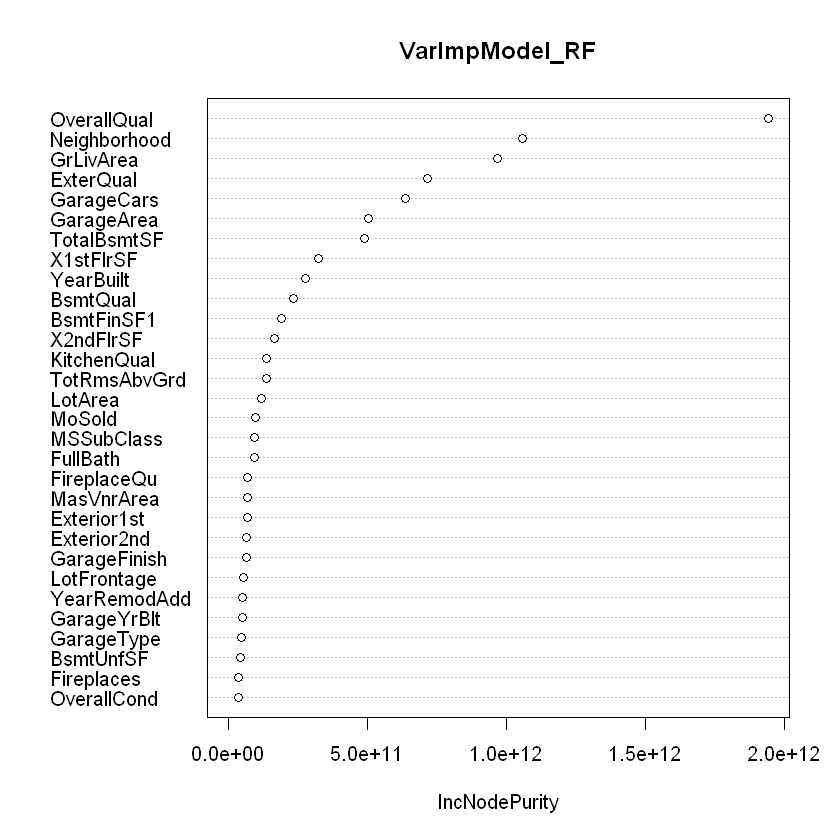

In [106]:
varImpPlot(VarImpModel_RF, type = 2)

In [107]:
# Keep only important variables (importance higher than for LotArea)
dataframePredictorV_only_ImpVar = subset(dataframePredictorV, select = c(LotArea, X2ndFlrSF, BsmtFinSF1, BsmtQual, GarageArea, YearBuilt,
                                         X1stFlrSF, KitchenQual, TotalBsmtSF, ExterQual, GarageCars,
                                         Neighborhood, GrLivArea, OverallQual))
#'BsmtQual' 'KitchenQual' 'ExterQual' 'GarageCars' 'Neighborhood'

In [108]:
head(dataframePredictorV_only_ImpVar, 10)

LotArea,X2ndFlrSF,BsmtFinSF1,BsmtQual,GarageArea,YearBuilt,X1stFlrSF,KitchenQual,TotalBsmtSF,ExterQual,GarageCars,Neighborhood,GrLivArea,OverallQual
328,233,362,Gd,221,105,135,Gd,180,Gd,2,CollgCr,532,7
499,1,483,Gd,150,78,428,TA,442,TA,2,Veenker,260,6
703,240,223,Gd,261,103,179,Gd,215,Gd,2,CollgCr,571,7
490,181,67,TA,285,20,209,Gd,118,TA,3,Crawfor,537,7
926,321,329,Gd,381,102,348,Gd,371,Gd,3,NoRidge,735,8
916,81,373,Gd,167,95,95,TA,141,TA,2,Mitchel,316,5
553,1,595,Ex,282,106,645,Gd,634,Gd,2,Somerst,521,8
594,299,437,Gd,171,75,318,TA,347,TA,2,NWAmes,702,7
139,178,1,TA,156,36,256,TA,238,TA,2,OldTown,566,7
223,1,434,TA,10,43,296,TA,270,TA,1,BrkSide,147,5


## Visualization of important variables

In [109]:
dataframePredictorV_only_ImpVar <- cbind(dataframePredictorV_only_ImpVar, dataframePredictorV_VarImp$HousePricesTargetV
)

In [110]:
colnames(dataframePredictorV_only_ImpVar)[length(dataframePredictorV_only_ImpVar)] <- "SalePrice"

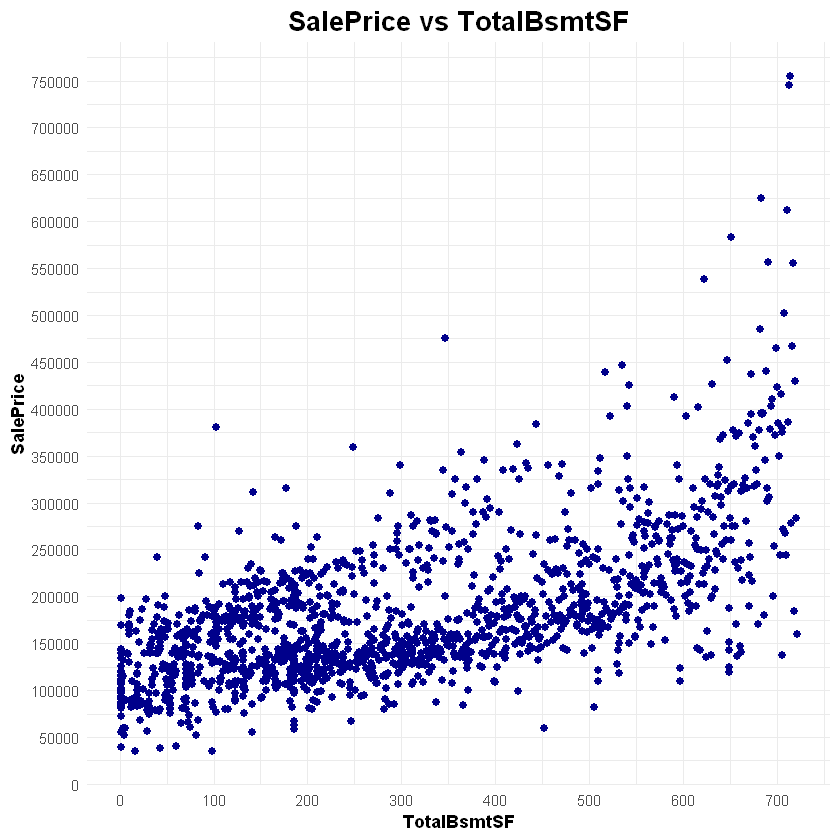

In [111]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = TotalBsmtSF, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 1250, 100)) + 
    labs(title = "SalePrice vs TotalBsmtSF") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16), axis.title = element_text(face = "bold"))

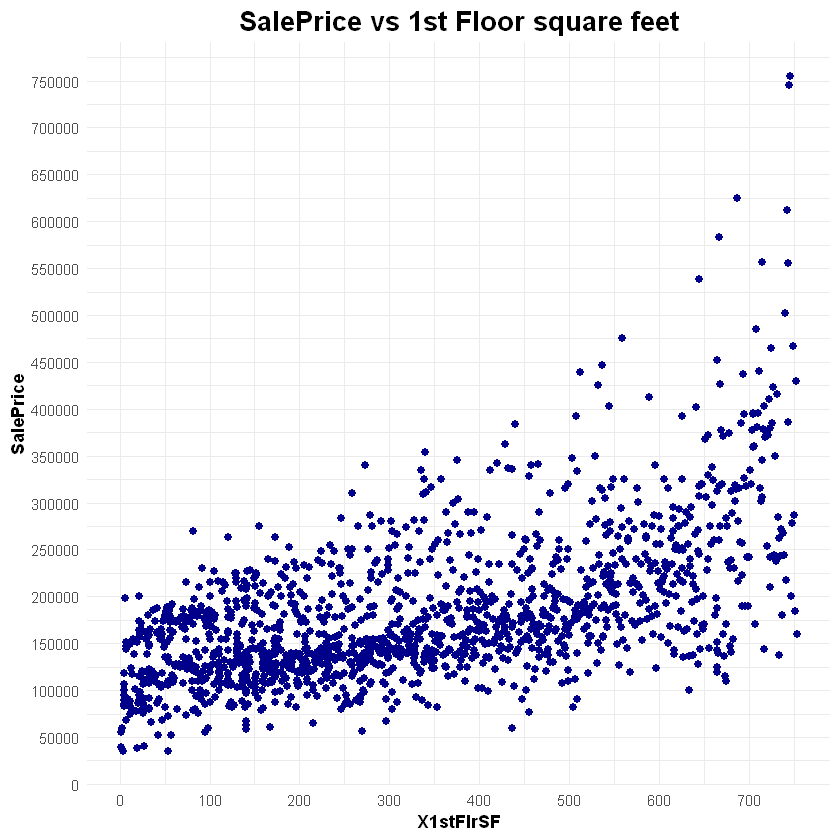

In [112]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = X1stFlrSF, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 1250, 100)) + 
    labs(title = "SalePrice vs 1st Floor square feet") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

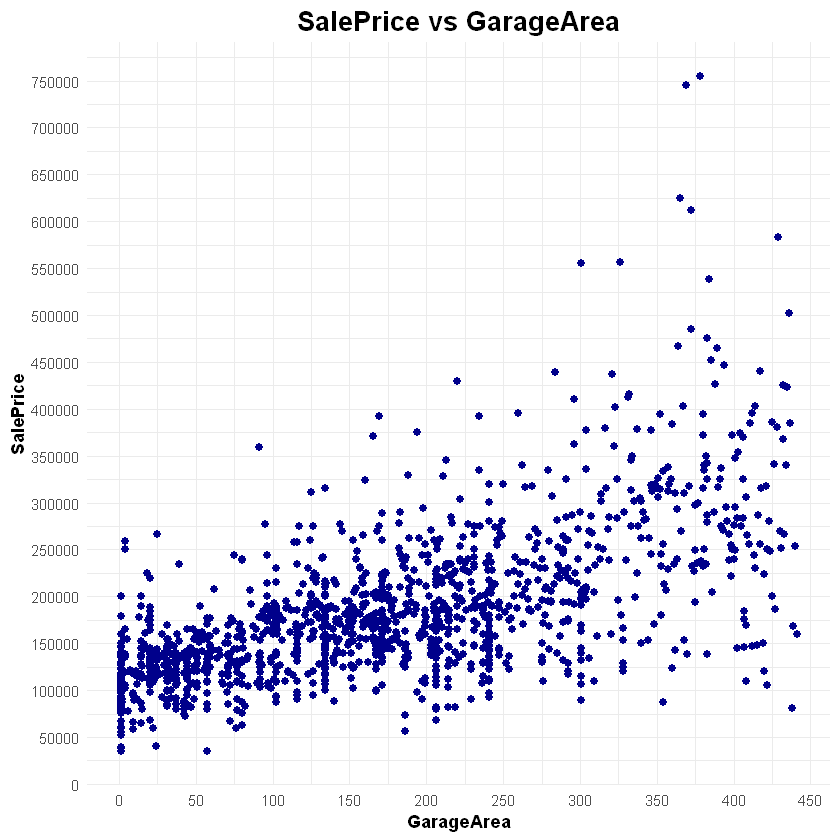

In [113]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = GarageArea, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 620, 50)) + 
    labs(title = "SalePrice vs GarageArea") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

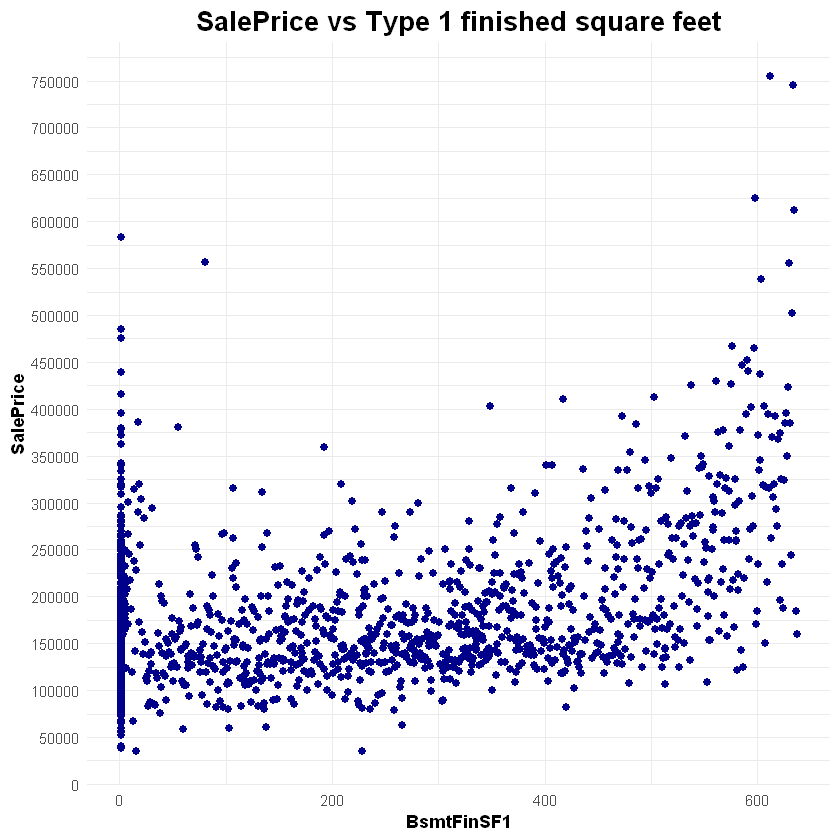

In [114]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = BsmtFinSF1, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    #scale_x_continuous(breaks = seq(0, 620, 50)) + 
    labs(title = "SalePrice vs Type 1 finished square feet") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

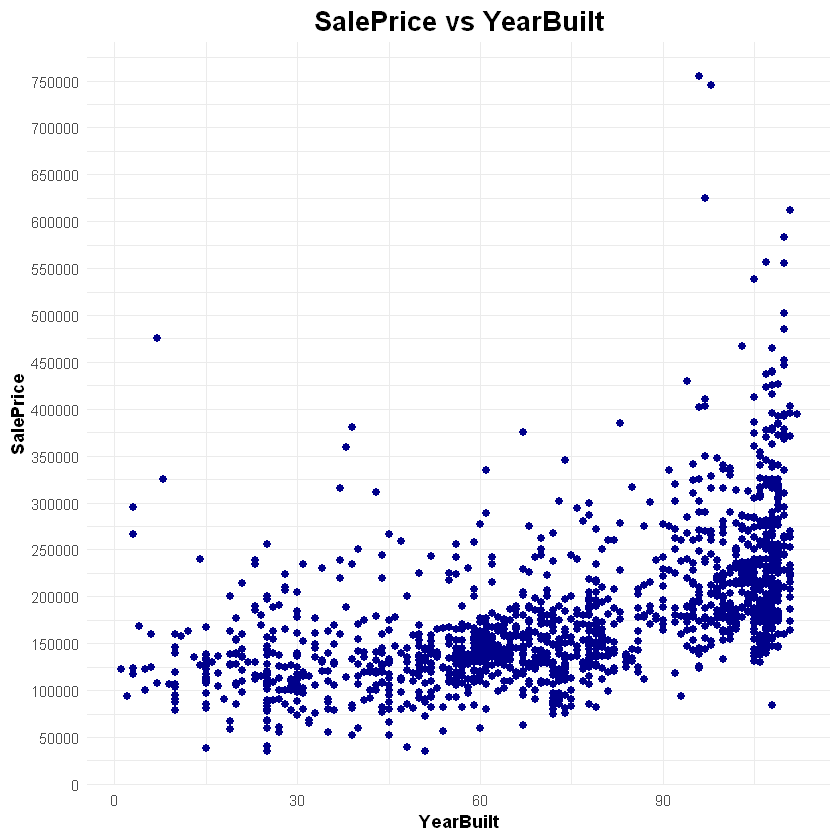

In [115]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = YearBuilt, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    #scale_x_continuous(breaks = seq(0, 620, 50)) + 
    labs(title = "SalePrice vs YearBuilt") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

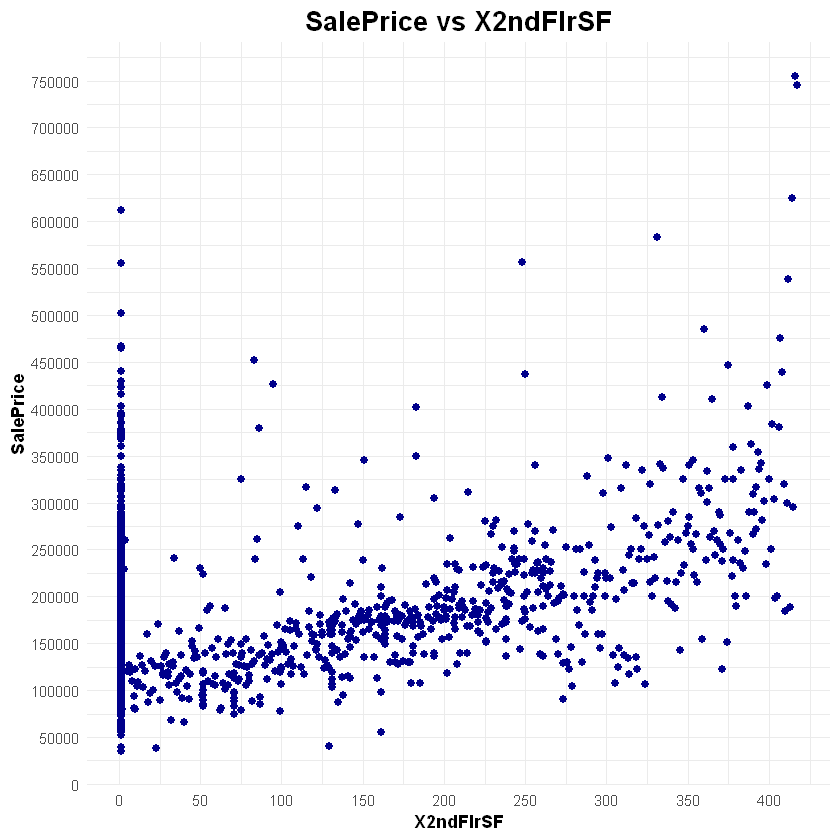

In [116]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = X2ndFlrSF, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 620, 50)) + 
    labs(title = "SalePrice vs X2ndFlrSF") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

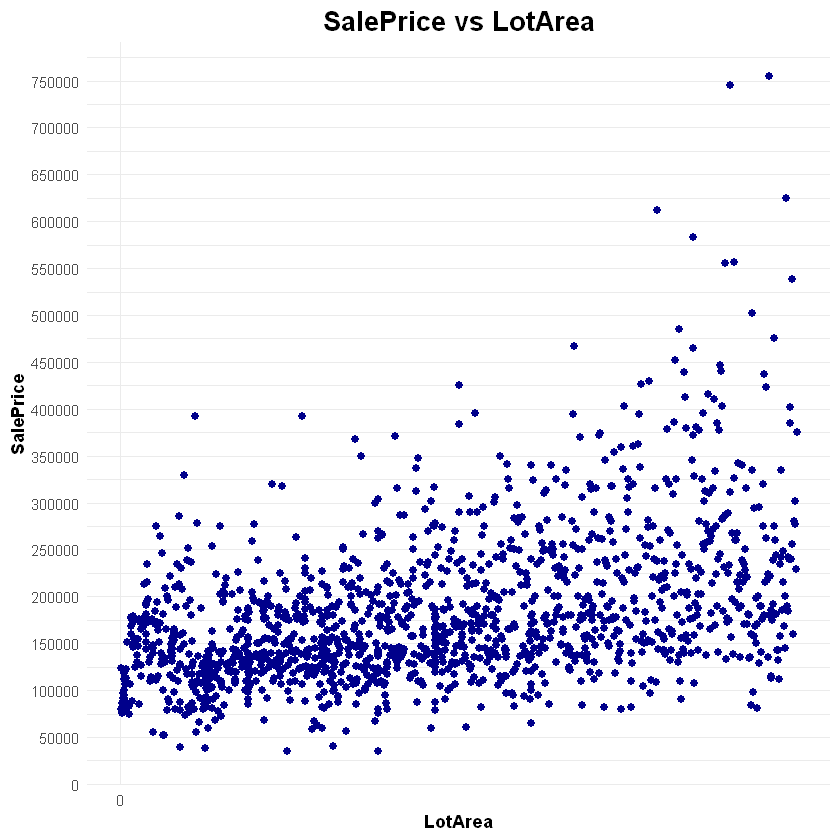

In [117]:
ggplot(dataframePredictorV_only_ImpVar, aes(x = LotArea, y = SalePrice)) +
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 250, 2000)) + 
    labs(title = "SalePrice vs LotArea") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

## Creating dummy variables

In [118]:
dataframePredictorV_ImpVar_categ <- which(unlist(lapply(dataframePredictorV_only_ImpVar, is.factor)))
names(dataframePredictorV_ImpVar_categ)

[1] "BsmtQual"     "KitchenQual"  "ExterQual"    "GarageCars"   "Neighborhood"

In [119]:
for(i in c(length(dataframePredictorV_ImpVar_categ):1)) {
    var_name <- paste(names(dataframePredictorV_ImpVar_categ)[i],'_dummy', sep = "")
    assign(var_name, factor(dataframePredictorV_only_ImpVar[, (dataframePredictorV_ImpVar_categ)[i]])) #dummy(dataframePredictorV_only_ImpVar[, (dataframePredictorV_ImpVar_categ)[i]]))
    var_name <- model.matrix(~get(var_name)) #drop last column to avoid dummy variable trap
    colnames(var_name) <- gsub('get\\(var_name\\)+', names(dataframePredictorV_ImpVar_categ)[i], colnames(var_name)) #correct column names
    #var_name <- get(var_name)[, -ncol(get(var_name))] #drop last column to avoid dummy variable trap
    dataframePredictorV_only_ImpVar <- subset(dataframePredictorV_only_ImpVar, select = -c(get(names(dataframePredictorV_ImpVar_categ)[i])))    # drop column var_name
    #dataframePredictorV_out <- dataframePredictorV_copy
    #dataframePredictorV <- cbind(dataframePredictorV, get(var_name))
    dataframePredictorV_only_ImpVar <- cbind(dataframePredictorV_only_ImpVar, var_name)
}

In [120]:
head(dataframePredictorV_only_ImpVar, 10)

LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,ExterQualTA,(Intercept).3,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept),BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA
328,233,362,221,105,135,180,532,7,208500,...,0,1,0,1,0,1,0,1,0,0
499,1,483,150,78,428,442,260,6,181500,...,1,1,0,0,1,1,0,1,0,0
703,240,223,261,103,179,215,571,7,223500,...,0,1,0,1,0,1,0,1,0,0
490,181,67,285,20,209,118,537,7,140000,...,1,1,0,1,0,1,0,0,0,1
926,321,329,381,102,348,371,735,8,250000,...,0,1,0,1,0,1,0,1,0,0
916,81,373,167,95,95,141,316,5,143000,...,1,1,0,0,1,1,0,1,0,0
553,1,595,282,106,645,634,521,8,307000,...,0,1,0,1,0,1,0,0,0,0
594,299,437,171,75,318,347,702,7,200000,...,1,1,0,0,1,1,0,1,0,0
139,178,1,156,36,256,238,566,7,129900,...,1,1,0,0,1,1,0,0,0,1
223,1,434,10,43,296,270,147,5,118000,...,1,1,0,0,1,1,0,0,0,1


## Remove outliers

In [121]:
# Checkif there is no missing values
miss4 = colSums(is.na(dataframePredictorV_only_ImpVar))
miss4

LotArea           X2ndFlrSF          BsmtFinSF1          GarageArea 
                  0                   0                   0                   0 
          YearBuilt           X1stFlrSF         TotalBsmtSF           GrLivArea 
                  0                   0                   0                   0 
        OverallQual           SalePrice         (Intercept) NeighborhoodBlueste 
                  0                   0                   0                   0 
 NeighborhoodBrDale NeighborhoodBrkSide NeighborhoodClearCr NeighborhoodCollgCr 
                  0                   0                   0                   0 
NeighborhoodCrawfor NeighborhoodEdwards NeighborhoodGilbert  NeighborhoodIDOTRR 
                  0                   0                   0                   0 
NeighborhoodMeadowV NeighborhoodMitchel   NeighborhoodNAmes NeighborhoodNoRidge 
                  0                   0                   0                   0 
NeighborhoodNPkVill NeighborhoodNridgHt  NeighborhoodNWAmes NeighborhoodOldTown 
                  0                   0                   0                   0 
 NeighborhoodSawyer NeighborhoodSawyerW NeighborhoodSomerst NeighborhoodStoneBr 
                  0                   0                   0                   0 
  NeighborhoodSWISU  NeighborhoodTimber NeighborhoodVeenker       (Intercept).1 
                  0                   0                   0                   0 
        GarageCars1         GarageCars2         GarageCars3         GarageCars4 
                  0                   0                   0                   0 
      (Intercept).2         ExterQualFa         ExterQualGd         ExterQualTA 
                  0                   0                   0                   0 
      (Intercept).3       KitchenQualFa       KitchenQualGd       KitchenQualTA 
                  0                   0                   0                   0 
        (Intercept)          BsmtQualFa          BsmtQualGd  BsmtQualNoBasement 
                  0                   0                   0                   0 
         BsmtQualTA 
                  0

In [122]:
names <- c('LotArea', 'X2ndFlrSF', 'BsmtFinSF1', 'BsmtQual', 'GarageArea', 'YearBuilt', 'X1stFlrSF',
            'TotalBsmtSF', 'GrLivArea', 'OverallQual')

In [123]:
for (i in length(names))
    qnt <- quantile(dataframePredictorV_only_ImpVar$names[i], probs=c(.25, .75), na.rm = T)
    caps <- quantile(dataframePredictorV_only_ImpVar$names[i], probs=c(.05, .95), na.rm = T)
    H <- 1.5 * IQR(dataframePredictorV_only_ImpVar$names[i], na.rm = T)
    dataframePredictorV_only_ImpVar$names[i][dataframePredictorV_only_ImpVar$names[i] < (qnt[1] - H)] <- caps[1]
    dataframePredictorV_only_ImpVar$names[i][dataframePredictorV_only_ImpVar$names[i] > (qnt[2] + H)] <- caps[2]

In [124]:
colSums(is.na(dataframePredictorV_only_ImpVar))

LotArea           X2ndFlrSF          BsmtFinSF1          GarageArea 
                  0                   0                   0                   0 
          YearBuilt           X1stFlrSF         TotalBsmtSF           GrLivArea 
                  0                   0                   0                   0 
        OverallQual           SalePrice         (Intercept) NeighborhoodBlueste 
                  0                   0                   0                   0 
 NeighborhoodBrDale NeighborhoodBrkSide NeighborhoodClearCr NeighborhoodCollgCr 
                  0                   0                   0                   0 
NeighborhoodCrawfor NeighborhoodEdwards NeighborhoodGilbert  NeighborhoodIDOTRR 
                  0                   0                   0                   0 
NeighborhoodMeadowV NeighborhoodMitchel   NeighborhoodNAmes NeighborhoodNoRidge 
                  0                   0                   0                   0 
NeighborhoodNPkVill NeighborhoodNridgHt  NeighborhoodNWAmes NeighborhoodOldTown 
                  0                   0                   0                   0 
 NeighborhoodSawyer NeighborhoodSawyerW NeighborhoodSomerst NeighborhoodStoneBr 
                  0                   0                   0                   0 
  NeighborhoodSWISU  NeighborhoodTimber NeighborhoodVeenker       (Intercept).1 
                  0                   0                   0                   0 
        GarageCars1         GarageCars2         GarageCars3         GarageCars4 
                  0                   0                   0                   0 
      (Intercept).2         ExterQualFa         ExterQualGd         ExterQualTA 
                  0                   0                   0                   0 
      (Intercept).3       KitchenQualFa       KitchenQualGd       KitchenQualTA 
                  0                   0                   0                   0 
        (Intercept)          BsmtQualFa          BsmtQualGd  BsmtQualNoBasement 
                  0                   0                   0                   0 
         BsmtQualTA 
                  0

In [125]:
head(dataframePredictorV_only_ImpVar)

LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,ExterQualTA,(Intercept).3,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept),BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA
328,233,362,221,105,135,180,532,7,208500,...,0,1,0,1,0,1,0,1,0,0
499,1,483,150,78,428,442,260,6,181500,...,1,1,0,0,1,1,0,1,0,0
703,240,223,261,103,179,215,571,7,223500,...,0,1,0,1,0,1,0,1,0,0
490,181,67,285,20,209,118,537,7,140000,...,1,1,0,1,0,1,0,0,0,1
926,321,329,381,102,348,371,735,8,250000,...,0,1,0,1,0,1,0,1,0,0
916,81,373,167,95,95,141,316,5,143000,...,1,1,0,0,1,1,0,1,0,0


## Feature Engineering

### Total area of the building

In [126]:
dataframePredictorV$TotalBuilArea <- dataframePredictorV$GrLivArea + dataframePredictorV$TotalBsmtSF

In [127]:
cor(head(dataframePredictorV_only_ImpVar$SalePrice, 1460), head(dataframePredictorV$TotalBuilArea, 1460))

[1] 0.7871074

In [128]:
dataframePredictorV_only_ImpVar$TotalBuilArea <- dataframePredictorV$TotalBuilArea

In [129]:
head(dataframePredictorV_only_ImpVar)

LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,(Intercept).3,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept),BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA,TotalBuilArea
328,233,362,221,105,135,180,532,7,208500,...,1,0,1,0,1,0,1,0,0,712
499,1,483,150,78,428,442,260,6,181500,...,1,0,0,1,1,0,1,0,0,702
703,240,223,261,103,179,215,571,7,223500,...,1,0,1,0,1,0,1,0,0,786
490,181,67,285,20,209,118,537,7,140000,...,1,0,1,0,1,0,0,0,1,655
926,321,329,381,102,348,371,735,8,250000,...,1,0,1,0,1,0,1,0,0,1106
916,81,373,167,95,95,141,316,5,143000,...,1,0,0,1,1,0,1,0,0,457


In [130]:
head(dataframePredictorV_only_ImpVar, 1460)

LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,(Intercept).3,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept),BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA,TotalBuilArea
328,233,362,221,105,135,180,532,7,208500,...,1,0,1,0,1,0,1,0,0,712
499,1,483,150,78,428,442,260,6,181500,...,1,0,0,1,1,0,1,0,0,702
703,240,223,261,103,179,215,571,7,223500,...,1,0,1,0,1,0,1,0,0,786
490,181,67,285,20,209,118,537,7,140000,...,1,0,1,0,1,0,0,0,1,655
926,321,329,381,102,348,371,735,8,250000,...,1,0,1,0,1,0,1,0,0,1106
916,81,373,167,95,95,141,316,5,143000,...,1,0,0,1,1,0,1,0,0,457
553,1,595,282,106,645,634,521,8,307000,...,1,0,1,0,1,0,0,0,0,1155
594,299,437,171,75,318,347,702,7,200000,...,1,0,0,1,1,0,1,0,0,1049
139,178,1,156,36,256,238,566,7,129900,...,1,0,0,1,1,0,0,0,1,804
223,1,434,10,43,296,270,147,5,118000,...,1,0,0,1,1,0,0,0,1,417


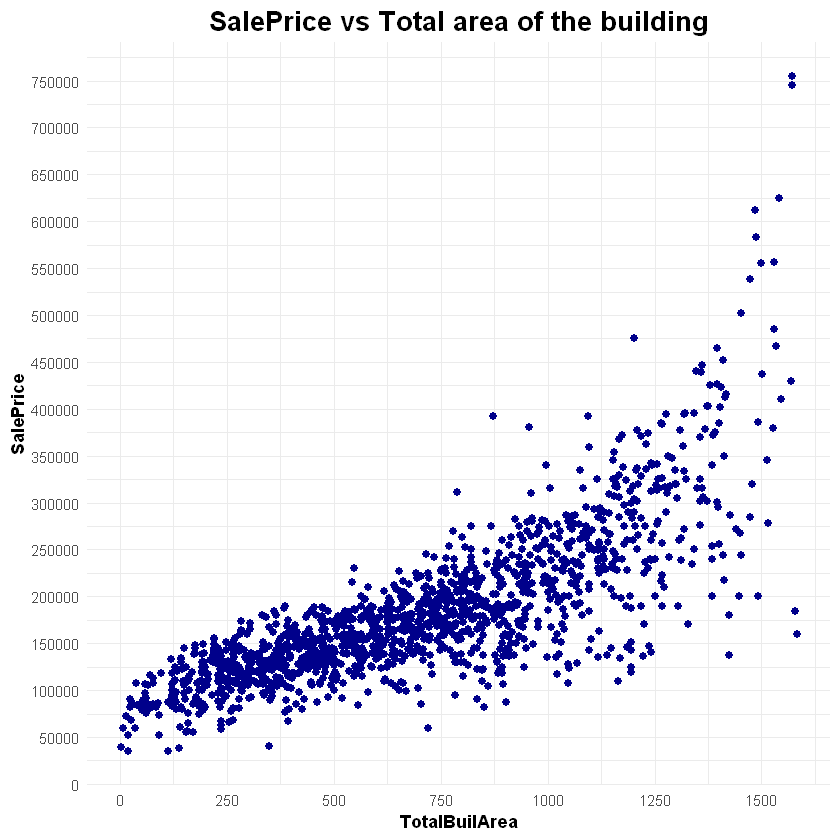

In [131]:
ggplot(subset(head(dataframePredictorV_only_ImpVar, 1460), select = c(SalePrice, TotalBuilArea)), aes(x = TotalBuilArea, y = SalePrice))+
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    scale_x_continuous(breaks = seq(0, 2500, 250)) + 
    labs(title = "SalePrice vs Total area of the building") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"))

### Distance to the center

In [132]:
summary(dataframePredictorV$Neighborhood)

Blmngtn Blueste  BrDale BrkSide ClearCr CollgCr Crawfor Edwards Gilbert  IDOTRR 
     17       2      16      58      28     150      51     100      79      37 
MeadowV Mitchel   NAmes NoRidge NPkVill NridgHt  NWAmes OldTown  Sawyer SawyerW 
     17      49     225      41       9      77      73     113      74      59 
Somerst StoneBr   SWISU  Timber Veenker 
     86      25      25      38      11

Distance in meters calculated as a straight line between center and selected district, basing on information from google maps and Ames city map (https://www.cityofames.org/home/showdocument?id=1024).
Blmngtn = 3050<br />
Blueste = 2330<br />
BrDale = 4090<br />
BrkSide = 478<br />
ClearCr = 1530<br />
CollgCr = 1810<br />
Crawfor = 1090<br />
Edwards = 4730<br />
Gilbert = 8590<br />
IDOTRR = 1260<br />
MeadowV = 4860<br />
Mitchel = 5210<br />
NAmes = 3260<br />
NoRidge = 2930<br />
NPkVill = 3250<br />
NridgHt = 2340<br />
NWAmes = 1920<br />
OldTown = 1470<br />
Sawyer = 3770<br />
SawyerW = 4290<br />
Somerst = 2650<br />
StoneBr = 3010<br />
SWISU = 1290<br />
Timber = 3730<br />
Veenker = 1920

In [133]:
#within(dataframePredictorV, test_Neighborhood <- factor(Neighborhood, labels = c(-1, 1, "")))
dataframePredictorV_only_ImpVar$DisttoCen <- revalue(dataframePredictorV$Neighborhood, c(Blmngtn = 3050, Blueste = 2330, BrDale = 4090, BrkSide = 478, ClearCr = 1530, CollgCr = 1810, Crawfor = 1090,
                                                 Edwards = 4730, Gilbert = 8590, IDOTRR = 1260, MeadowV = 4860, Mitchel = 5210, NAmes = 3260, NoRidge = 2930,
                                                 NPkVill = 3250, NridgHt = 2340, NWAmes = 1920, OldTown = 1470, Sawyer = 3770, SawyerW = 4290, Somerst = 2650,
                                                 StoneBr = 3010, SWISU = 1290, Timber = 3730, Veenker = 1920))

In [134]:
DF_DisttoCen <- subset(head(dataframePredictorV_only_ImpVar, 1460), select = c(SalePrice, DisttoCen))

In [135]:
DF_DisttoCen$DisttoCen <- as.numeric(as.character(DF_DisttoCen$DisttoCen))

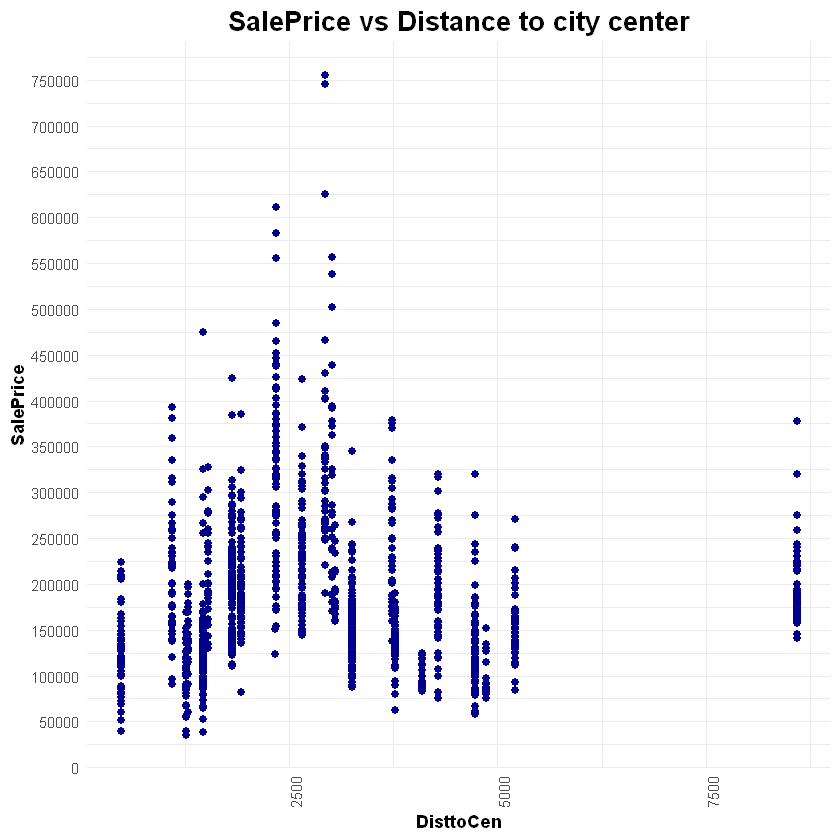

In [136]:
ggplot(DF_DisttoCen[order(DF_DisttoCen$DisttoCen), ], aes(x = DisttoCen, y = SalePrice))+
    geom_point(shape = 16, size = 2, show.legend = FALSE, color = 'darkblue') +
    theme_minimal() +
    scale_y_continuous(breaks = seq(0, 800000, 50000)) +
    #scale_x_discrete(breaks = seq(0, 10000, 500)) + 
    labs(title = "SalePrice vs Distance to city center") +
    theme(plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
          axis.title = element_text(face = "bold"),
          axis.text.x = element_text(angle = 90, hjust = 1))

## Model creation

In [137]:
# Spliting HousePricesDataset into training and test sets
set.seed(123)
split <- sample.split(dataframePredictorV_only_ImpVar$SalePrice, SplitRatio = 0.8)
training_set <- subset(dataframePredictorV_only_ImpVar, split == TRUE)
test_set <- subset(dataframePredictorV_only_ImpVar, split == FALSE)

In [138]:
dim(dataframePredictorV_only_ImpVar)

[1] 1460   55

In [139]:
head(training_set, 10)

,LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept).4,BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA,TotalBuilArea,DisttoCen
1,328,233,362,221,105,135,180,532,7,208500,...,0,1,0,1,0,1,0,0,712,1810
2,499,1,483,150,78,428,442,260,6,181500,...,0,0,1,1,0,1,0,0,702,1920
3,703,240,223,261,103,179,215,571,7,223500,...,0,1,0,1,0,1,0,0,786,1810
5,926,321,329,381,102,348,371,735,8,250000,...,0,1,0,1,0,1,0,0,1106,2930
6,916,81,373,167,95,95,141,316,5,143000,...,0,0,1,1,0,1,0,0,457,5210
7,553,1,595,282,106,645,634,521,8,307000,...,0,1,0,1,0,0,0,0,1155,2650
8,594,299,437,171,75,318,347,702,7,200000,...,0,0,1,1,0,1,0,0,1049,1920
9,139,178,1,156,36,256,238,566,7,129900,...,0,0,1,1,0,0,0,1,804,1470
10,223,1,434,10,43,296,270,147,5,118000,...,0,0,1,1,0,0,0,1,417,478
11,692,1,459,92,67,267,301,126,5,129500,...,0,0,1,1,0,0,0,1,427,3770


In [140]:
typeof(subset(training_set, select = -length(training_set)))

[1] "list"

In [141]:
colnames(training_set)[length(training_set)] <- "SalePrice"

In [142]:
grid <- expand.grid(.alpha = seq(0, 1, by = .5), .lambda=seq(0, 0.2, by = .1))

In [143]:
control <- trainControl(method = "LOOCV")

In [144]:
names(training_set) <- make.unique(names(training_set))

In [145]:
enet.train <- train(SalePrice ~ ., training_set, method = "glmnet",
                    trControl = control, tuneGrid = grid)
enet.train

glmnet 

1258 samples
  54 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 1257, 1257, 1257, 1257, 1257, 1257, ... 
Resampling results across tuning parameters:

  alpha  lambda  RMSE      Rsquared   MAE     
  0.0    0.0     32668.90  0.8440315  20023.48
  0.0    0.1     32668.90  0.8440315  20023.48
  0.0    0.2     32668.90  0.8440315  20023.48
  0.5    0.0     32616.16  0.8444110  20066.80
  0.5    0.1     32616.16  0.8444110  20066.80
  0.5    0.2     32616.16  0.8444110  20066.80
  1.0    0.0     32597.30  0.8445912  20061.52
  1.0    0.1     32597.30  0.8445912  20061.52
  1.0    0.2     32597.30  0.8445912  20061.52

RMSE was used to select the optimal model using the smallest value.
The final values used for the model were alpha = 1 and lambda = 0.2.

In [146]:
predictor_variables <- as.matrix(training_set[, -length(training_set)])
SalePrice <- as.matrix(training_set$SalePrice)
predictor_variables <- subset(predictor_variables, select = -c(SalePrice))
enet <- glmnet(predictor_variables, SalePrice, family = "gaussian", alpha = 0, lambda = .2)

## Predicting results for a test set

In [147]:
test_set_matrix = as.matrix(test_set[, -length(test_set)])

In [148]:
head(test_set_matrix, 10)

,LotArea,X2ndFlrSF,BsmtFinSF1,GarageArea,YearBuilt,X1stFlrSF,TotalBsmtSF,GrLivArea,OverallQual,SalePrice,...,(Intercept).3,KitchenQualFa,KitchenQualGd,KitchenQualTA,(Intercept).4,BsmtQualFa,BsmtQualGd,BsmtQualNoBasement,BsmtQualTA,TotalBuilArea
4,490,181,67,285,20,209,118,537,7,140000,...,1,0,1,0,1,0,0,0,1,655
13,854,1,377,77,64,173,210,70,5,144000,...,1,0,0,1,1,0,0,0,1,280
24,71,1,430,237,78,282,301,137,5,129900,...,1,0,0,1,1,0,1,0,0,438
29,982,1,574,62,59,601,552,460,5,207500,...,1,0,0,1,1,0,0,0,1,1012
33,675,1,1,171,109,409,423,243,8,179900,...,1,0,1,0,1,0,0,0,0,666
34,615,1,504,139,61,649,513,525,5,165500,...,1,0,1,0,1,0,0,0,1,1038
37,657,1,1,301,96,311,339,158,5,145000,...,1,0,0,1,1,0,1,0,0,497
43,436,1,383,186,85,152,169,58,5,144000,...,1,0,1,0,1,0,1,0,0,227
45,275,1,47,51,61,352,374,197,5,141000,...,1,0,0,1,1,0,0,0,1,571
67,1021,1,460,241,72,737,686,738,7,180000,...,1,0,0,1,1,0,1,0,0,1424


In [149]:
enet.y_pred <- predict(enet, newx = subset(test_set_matrix, select = -c(SalePrice)), type = "response", lambda = .2, alpha = 0)

In [150]:
length(enet.y_pred)

[1] 202

## Summary

In [151]:
summary(enet.train)

            Length Class      Mode     
a0            79   -none-     numeric  
beta        5609   dgCMatrix  S4       
df            79   -none-     numeric  
dim            2   -none-     numeric  
lambda        79   -none-     numeric  
dev.ratio     79   -none-     numeric  
nulldev        1   -none-     numeric  
npasses        1   -none-     numeric  
jerr           1   -none-     numeric  
offset         1   -none-     logical  
call           5   -none-     call     
nobs           1   -none-     numeric  
lambdaOpt      1   -none-     numeric  
xNames        71   -none-     character
problemType    1   -none-     character
tuneValue      2   data.frame list     
obsLevels      1   -none-     logical  
param          0   -none-     list     

In [152]:
# Model prediction performance
data.frame(
  RMSE = RMSE(enet.y_pred, test_set$SalePrice),
  Rsquare = R2(enet.y_pred, test_set$SalePrice)
)

RMSE,s0
23782.2,0.8348647
